In [1]:
import pandas as pd
import aesara_theano_fallback.tensor as tt
import exoplanet as xo

import pymc3 as pm
import pymc3_ext as pmx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
import pickle
import seaborn as sns
from astropy.io import ascii
from datetime import date

from MonoTools.MonoTools import tools, lightcurve

sns.set_style('white')

from matplotlib import rc
rc('text', usetex=True)
rc('font', size=14)
rc('legend', fontsize=13)
rc('text.latex', preamble=r'\usepackage{cmbright}')

plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}"]
#Options
params = {'text.usetex' : True,
          'font.size' : 12,
          'font.family' : 'lmodern'
          }
plt.rcParams.update(params) 

viridis_light='#580066,#592f93,#405ea6,#0085a9,#00aaa4,#00cc92,#00ec62,#afff00,#feff00'.split(',')
sns.set_palette(viridis_light)


Matplotlib created a temporary config/cache directory at /var/folders/p0/tmr0j01x4jb3qrbc5b0gnxcw0000gn/T/matplotlib-vwl7uueh because the default path (/Users/hosborn/.matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Getting all IDs
Accessing online catalogues to match ID to RA/Dec (may be slow) mission= tess
Empty TableList
Sector 46 not (yet) found on MAST | RESPONCE:404
Sector 47 not (yet) found on MAST | RESPONCE:404


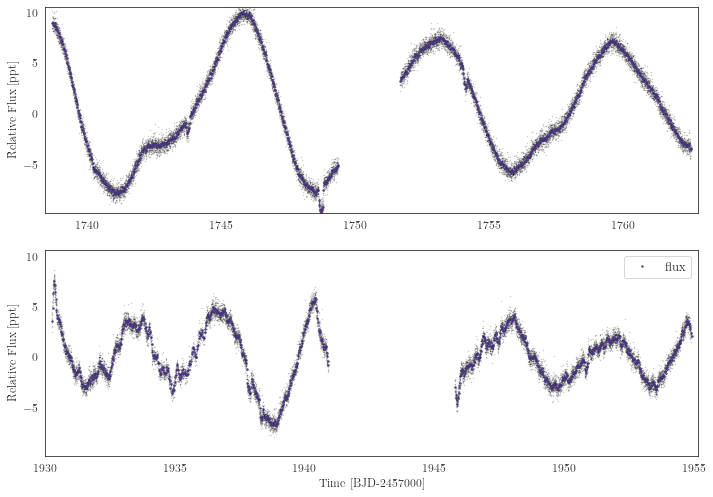

In [2]:
lc=lightcurve.multilc(27491137,'tess',load=False)
lc.plot()


In [328]:
#from MonoTools.MonoTools import lightcurve,tools
#lc=lightcurve.multilc(4646810,'tess',load=True)
past_modelling=pd.read_csv('/Volumes/LUVOIR/Cheops_data/TOI2076/CombModelOutputs/TOI2076_finalmodel_P35_circ_ncbaenwgr_na_nogp_nocontam_fixld_add_parameter_groups_pmxsample_20211125_results.csv',index_col=0)
#"/Volumes/LUVOIR/MonoToolsData/TIC00027491137/TIC00027491137_2021-06-29_1_mcmc_output_short.csv",index_col=0)

tess_in_trans   = np.tile(False,len(lc.time))
init_transit_times={}
init_transit_inds={}
info={}

for pl in range(3):
    info[pl]={}
    info[pl]['t0']=past_modelling.loc['t0['+str(pl)+']','mean']
    if pl==0:
        info[pl]['p']=past_modelling.loc['derived_period['+str(pl)+']','mean']
    elif pl==1:
        info[pl]['p']=past_modelling.loc['derived_period['+str(pl)+']','mean']
    else:
        info[pl]['p']=past_modelling.loc['derived_period['+str(pl)+']','mean']
    info[pl]['dur'] = np.random.normal(past_modelling.loc['tdur['+str(pl)+']','mean'],
                                       2.5*past_modelling.loc['tdur['+str(pl)+']','sd'])/24
    tess_phase=abs((lc.time-info[pl]['t0']-0.5*info[pl]['p'])%info[pl]['p']-0.5*info[pl]['p'])
    tess_in_trans+=tess_phase<0.55*info[pl]['dur']
    
    # Getting the transit time centres:
    tcens=info[pl]['t0']+np.arange(-100,150)*info[pl]['p']


In [29]:
#lc.flux[lc.cadence=='ts_120_pdc_23']=lc.raw_flux[lc.cadence=='ts_120_pdc_23']
#lc.mask[lc.cadence=='ts_120_pdc_23']=~np.isnan(lc.raw_flux[lc.cadence=='ts_120_pdc_23'])
lc.flux=lc.raw_flux
lc.mask=~np.isnan(lc.raw_flux)
out=tools.kepler_spline(lc.time,lc.flux,flux_mask=lc.mask,transit_mask=~tess_in_trans,bk_space=0.8,reflect=False)

(1735.0, 1765.0)

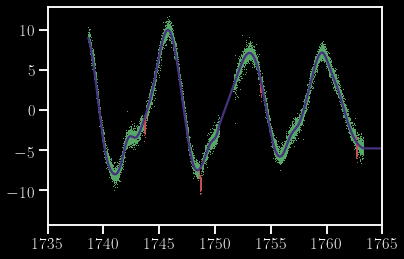

In [30]:
plt.plot(lc.time[lc.mask],lc.flux[lc.mask],',g')
plt.plot(lc.time[lc.mask&tess_in_trans],lc.flux[lc.mask&tess_in_trans],',r')
plt.plot(lc.time,out[0])
plt.xlim(1735,1765)

In [10]:
alldata = pickle.load(open("all_data_for_combined_model.pkl","rb"))
#trace = pickle.load(open("/Volumes/LUVOIR/Cheops_data/TOI2076/CombModelOutputs/TOI2076_finalmodel_P35_circ_ncbaenwgr_na_nogp_nocontam_fixld_testing_entropy_correlations2_20211117_trace(logp=-2511.3).pkl","rb"))
#pickle.load(open("/Volumes/LUVOIR/Cheops_data/TOI2076/CombModelOutputs/TOI2076_finalmodel_P35_circ_nscsdbanwcgr_na_nogp_nocontam_20211104_trace(logp=1130.9).pkl","rb"))
#/Volumes/LUVOIR/Cheops_data/TOI2076/CombModelOutputs/TOI2076_finalmodel_P35_circ_nscsdbanwcgr_na_nogp_nocontam_20211103_trace(logp=1023.8).pkl","rb"))
#    "TOI2076_finalmodel_P35_circ_nscsdbanwc_na_nogp_nocontam_trace(logp=-3704.3).pkl","rb"))

In [31]:
ix0=np.argmin(abs(alldata['tess']['time'][alldata['tess']['time']<1900,None]-lc.time[None,lc.time<1900]),axis=1)
ix1=np.argmin(abs(alldata['tess']['time'][alldata['tess']['time']>1900,None]-lc.time[None,lc.time>1900]),axis=1)

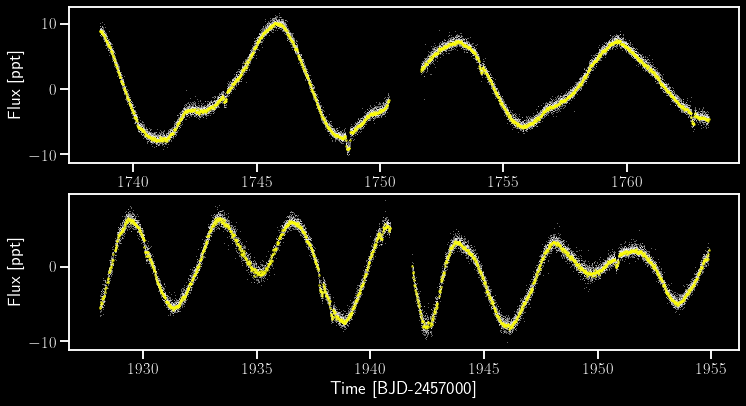

In [211]:
import seaborn as sns
sns.set(style="ticks", context="talk")
plt.style.use("dark_background")
sns.set_palette(viridis_light)
plt.figure(figsize=(12,6.3))
plt.subplot(211)
plt.plot(alldata['tess']['time'][alldata['tess']['time']<1900],alldata['tess']['flux'][alldata['tess']['time']<1900]+out[0][lc.time<1900][ix0],',w',alpha=0.4)
binlc=tools.bin_lc_segment(np.column_stack((alldata['tess']['time'][alldata['tess']['time']<1900],
                                            alldata['tess']['flux'][alldata['tess']['time']<1900]+out[0][lc.time<1900][ix0],
                                            alldata['tess']['flux_err'][alldata['tess']['time']<1900])),1/48)
plt.plot(binlc[:,0],binlc[:,1],'.',color='C8',alpha=0.5,markersize=3.5)
plt.ylabel("Flux [ppt]")
plt.subplot(212)
plt.plot(alldata['tess']['time'][alldata['tess']['time']>1900],alldata['tess']['flux'][alldata['tess']['time']>1900]+out[0][lc.time>1900][ix1],',w',alpha=0.4)
binlc=tools.bin_lc_segment(np.column_stack((alldata['tess']['time'][alldata['tess']['time']>1900],
                                            alldata['tess']['flux'][alldata['tess']['time']>1900]+out[0][lc.time>1900][ix1],
                                            alldata['tess']['flux_err'][alldata['tess']['time']>1900])),1/48)
plt.plot(binlc[:,0],binlc[:,1],'.',color='C8',alpha=0.5,markersize=3.5)
plt.ylabel("Flux [ppt]")
plt.xlabel("Time [BJD-2457000]")
plt.savefig("talk_raw_lc.png",transparent=True)

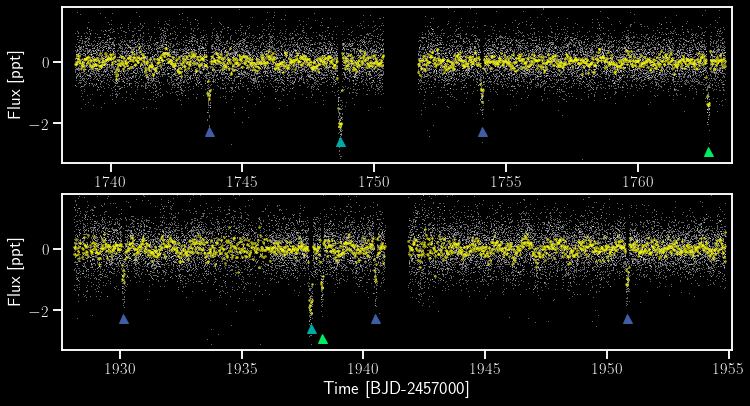

In [213]:
import seaborn as sns
sns.set(style="ticks", context="talk")
plt.style.use("dark_background")
sns.set_palette(viridis_light)
plt.figure(figsize=(12,6.3))
plt.subplot(211)
plt.plot(alldata['tess']['time'][alldata['tess']['time']<1900],alldata['tess']['flux'][alldata['tess']['time']<1900],',w',alpha=0.4)
binlc=tools.bin_lc_segment(np.column_stack((alldata['tess']['time'][alldata['tess']['time']<1900],
                                            alldata['tess']['flux'][alldata['tess']['time']<1900],
                                            alldata['tess']['flux_err'][alldata['tess']['time']<1900])),1/48)
plt.plot(binlc[:,0],binlc[:,1],'.',color='C8',alpha=0.5,markersize=3.5)
plt.ylim(-3.3,1.8)
for n,pl in enumerate(info):
    trans=np.arange(np.floor((binlc[0,0]-info[pl]['t0'])/info[pl]['p']),
              np.ceil((binlc[-1,0]-info[pl]['t0'])/info[pl]['p']))
    plt.plot(info[pl]['t0']+info[pl]['p']*trans,np.tile(-2.25-n*0.333,len(trans)),'^',c='C'+str(2+2*n))
plt.xlim(binlc[0,0]-0.5,binlc[-1,0]+0.25)
plt.ylabel("Flux [ppt]")
plt.subplot(212)
plt.plot(alldata['tess']['time'][alldata['tess']['time']>1900],alldata['tess']['flux'][alldata['tess']['time']>1900],',w',alpha=0.4)
binlc=tools.bin_lc_segment(np.column_stack((alldata['tess']['time'][alldata['tess']['time']>1900],
                                            alldata['tess']['flux'][alldata['tess']['time']>1900],
                                            alldata['tess']['flux_err'][alldata['tess']['time']>1900])),1/48)
plt.plot(binlc[:,0],binlc[:,1],'.',color='C8',alpha=0.5,markersize=3.5)

for n,pl in enumerate(info):
    trans=np.arange(np.floor((binlc[0,0]-info[pl]['t0'])/info[pl]['p']),
              np.ceil((binlc[-1,0]-info[pl]['t0'])/info[pl]['p']))
    plt.plot(info[pl]['t0']+info[pl]['p']*trans,np.tile(-2.25-n*0.333,len(trans)),'^',c='C'+str(2+2*n))
plt.xlim(binlc[0,0]-0.5,binlc[-1,0]+0.25)
plt.ylabel("Flux [ppt]")
plt.xlabel("Time [BJD-2457000]")
plt.ylim(-3.3,1.8)
plt.savefig("talk_det_lc.png",transparent=True)


In [58]:
allpls=ascii.read("PS_2022.01.11_07.00.30.csv").to_pandas()
youngpls=pd.read_csv("/Users/hosborn/Downloads/young_planets.csv",comment='#')

In [115]:
thresh=4
filtdf=allpls.loc[(allpls['default_flag']==1)&(~np.isnan(allpls['pl_radeerr1']))&(allpls['tran_flag']==1)&(~np.isnan(allpls['pl_rade']))&((allpls['pl_radeerr1']/allpls['pl_rade'])<thresh)&((abs(allpls['pl_radeerr2'])/allpls['pl_rade'])<thresh)]
#&(allpls['pl_refname']!='<a refstr=HADDEN_ET_AL__2014 href=https://ui.adsabs.harvard.edu/abs/2014ApJ...787...80H/abstract target=ref> Hadden et al. 2014 </a>')&(allpls['pl_refname']!='<a refstr=XIE_2014 href=https://ui.adsabs.harvard.edu/abs/2014ApJS..210...25X/abstract target=ref>Xie 2014</a>')]


In [116]:
filtdf.columns

Index(['rowid', 'pl_name', 'hostname', 'pl_letter', 'hd_name', 'hip_name',
       'tic_id', 'gaia_id', 'default_flag', 'sy_snum',
       ...
       'sy_kepmagerr2', 'rowupdate', 'pl_pubdate', 'releasedate', 'pl_nnotes',
       'st_nphot', 'st_nrvc', 'st_nspec', 'pl_nespec', 'pl_ntranspec'],
      dtype='object', length=287)

In [117]:
filtdf.loc[filtdf['disc_facility']!='Transiting Exoplanet Survey Satellite (TESS)','disc_facility'].shape

(3202,)

In [118]:
','.join(filtdf.columns.values)

'rowid,pl_name,hostname,pl_letter,hd_name,hip_name,tic_id,gaia_id,default_flag,sy_snum,sy_pnum,sy_mnum,cb_flag,discoverymethod,disc_year,disc_refname,disc_pubdate,disc_locale,disc_facility,disc_telescope,disc_instrument,rv_flag,pul_flag,ptv_flag,tran_flag,ast_flag,obm_flag,micro_flag,etv_flag,ima_flag,dkin_flag,soltype,pl_controv_flag,pl_refname,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_orbperlim,pl_orbsmax,pl_orbsmaxerr1,pl_orbsmaxerr2,pl_orbsmaxlim,pl_rade,pl_radeerr1,pl_radeerr2,pl_radelim,pl_radj,pl_radjerr1,pl_radjerr2,pl_radjlim,pl_masse,pl_masseerr1,pl_masseerr2,pl_masselim,pl_massj,pl_massjerr1,pl_massjerr2,pl_massjlim,pl_msinie,pl_msinieerr1,pl_msinieerr2,pl_msinielim,pl_msinij,pl_msinijerr1,pl_msinijerr2,pl_msinijlim,pl_cmasse,pl_cmasseerr1,pl_cmasseerr2,pl_cmasselim,pl_cmassj,pl_cmassjerr1,pl_cmassjerr2,pl_cmassjlim,pl_bmasse,pl_bmasseerr1,pl_bmasseerr2,pl_bmasselim,pl_bmassj,pl_bmassjerr1,pl_bmassjerr2,pl_bmassjlim,pl_bmassprov,pl_dens,pl_denserr1,pl_denserr2,pl_denslim,pl_o

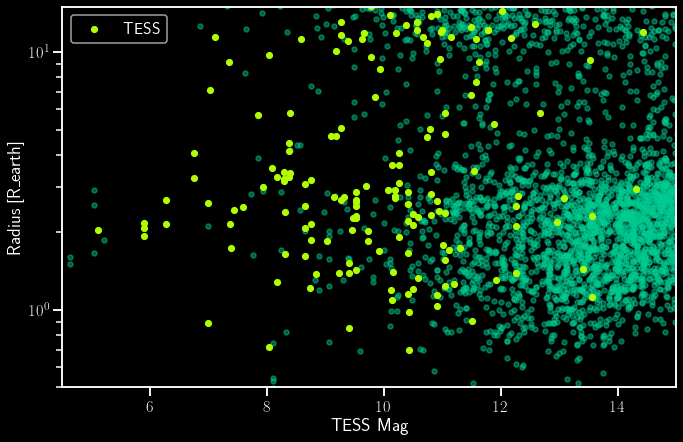

In [219]:
plt.figure(figsize=(11,7))
sns.set_palette(viridis_light)

ix2=filtdf['disc_facility']!='Transiting Exoplanet Survey Satellite (TESS)'
plt.scatter(filtdf.loc[ix2,'sy_tmag'],filtdf.loc[ix2,'pl_rade'],alpha=0.45,s=25,c='C5')
ix=filtdf['disc_facility']=='Transiting Exoplanet Survey Satellite (TESS)'
plt.scatter(filtdf.loc[ix,'sy_tmag'],filtdf.loc[ix,'pl_rade'],alpha=1,s=32,c='C7',label='TESS')
plt.legend()
#plt.xscale('log')
plt.yscale('log')
plt.xlim(4.5,15)
plt.ylim(0.5,15)
plt.ylabel("Radius [R\_earth]")
plt.xlabel("TESS Mag")
plt.savefig("talk_transpls_by_mag.png",dpi=400,transparent=True)

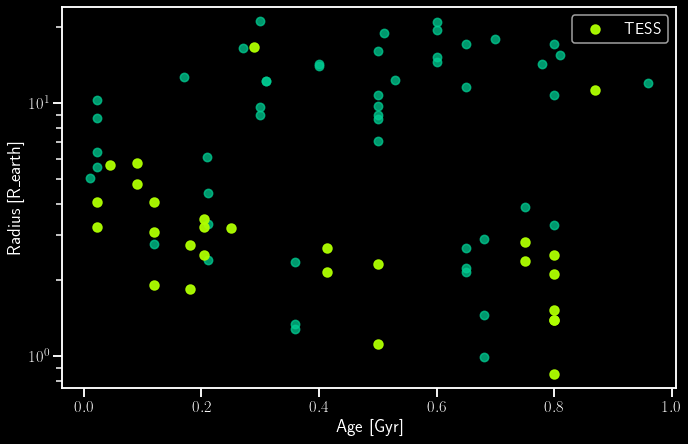

In [220]:
plt.figure(figsize=(11,7))
sns.set_palette(viridis_light)

ix2=(youngpls['default_flag']==1)&(youngpls['disc_facility']!="Transiting Exoplanet Survey Satellite (TESS)")
plt.scatter(youngpls.loc[ix2,'st_age'],youngpls.loc[ix2,'pl_rade'],alpha=0.75,s=70,c='C5')

ix=(youngpls['default_flag']==1)&(youngpls['disc_facility']=="Transiting Exoplanet Survey Satellite (TESS)")
plt.scatter(youngpls.loc[ix,'st_age'],youngpls.loc[ix,'pl_rade'],alpha=0.95,s=80,c='C7',label='TESS')

plt.yscale('log')
plt.ylim(0.75,24)
plt.ylabel("Radius [R\_earth]")
plt.xlabel("Age [Gyr]")
plt.legend()
plt.savefig("talk_transpls_by_age.png",dpi=400,transparent=True)

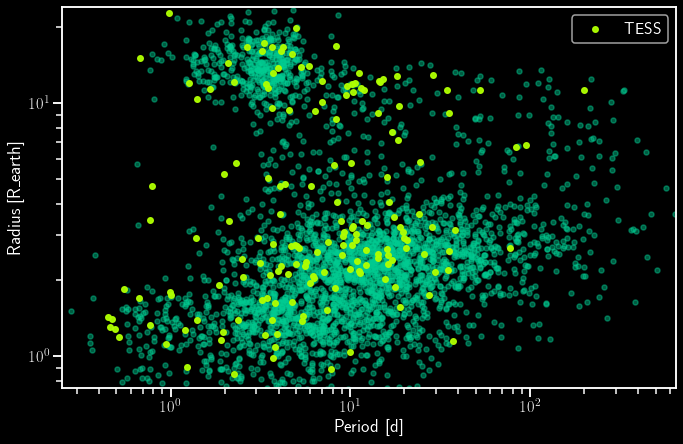

In [221]:
sns.set_palette(viridis_light)

plt.figure(figsize=(11,7))
ix2=filtdf['disc_facility']!='Transiting Exoplanet Survey Satellite (TESS)'
plt.scatter(filtdf.loc[ix2,'pl_orbper'],filtdf.loc[ix2,'pl_rade'],alpha=0.45,s=25,c='C5')
ix=filtdf['disc_facility']=='Transiting Exoplanet Survey Satellite (TESS)'
plt.scatter(filtdf.loc[ix,'pl_orbper'],filtdf.loc[ix,'pl_rade'],alpha=0.95,s=30,c='C7',label='TESS')

plt.yscale('log')
plt.ylim(0.75,24)
plt.xlim(0.25,650)
plt.xscale('log')

plt.ylabel("Radius [R\_earth]")
plt.xlabel("Period [d]")
plt.legend()
plt.savefig("talk_transpls_by_per.png",dpi=400,transparent=True)

In [51]:
import glob
import gzip
import pickle

filename='P35_circ_ncbaenwgr_na_nogp_nocontam_fixld_35d_fixed_ror_vals_20211205'
save_loc="/Volumes/LUVOIR/Cheops_data/TOI2076/CombModelOutputs/"

bytes_in = bytearray(0)
max_bytes = 2**31 - 1
for file in glob.glob(save_loc+"TOI2076_finalmodel_"+filename+"_trace*gz"):
    with gzip.open(file, 'rb') as f_in:
        bytes_in += f_in.read(max_bytes)
trace = pickle.loads(bytes_in)

In [52]:
import glob
import gzip
import pickle

filename='P35_circ_ncbaenwgr_na_nogp_nocontam_fixld_add_parameter_groups_pmxsample_20211125'
save_loc="/Volumes/LUVOIR/Cheops_data/TOI2076/CombModelOutputs/"

bytes_in = bytearray(0)
max_bytes = 2**31 - 1
for file in glob.glob(save_loc+"TOI2076_finalmodel_"+filename+"_trace*gz"):
    with gzip.open(file, 'rb') as f_in:
        bytes_in += f_in.read(max_bytes)
oldtrace = pickle.loads(bytes_in)

In [164]:
df=pd.read_csv(glob.glob(save_loc+"TOI2076_finalmodel_"+filename+"*.csv")[0],index_col=0)

In [165]:
filename='P35_circ_ncbaenwgr_na_nogp_nocontam_fixld_looserlds_pargroups_allscopes_20211125'
df=pd.read_csv(glob.glob(save_loc+"TOI2076_finalmodel_"+filename+"*.csv")[0],index_col=0)
filename='P35_circ_ncbaenwgr_na_nogp_nocontam_fixld_add_parameter_groups_pmxsample_20211125'
olddf=pd.read_csv(glob.glob(save_loc+"TOI2076_finalmodel_"+filename+"*.csv")[0],index_col=0)

### Figures and Tables

Figures:
* Photometry from all 6 filters/telescopes detrended for each P=25 and P=35d models
* Photometry from all 4 Cheops visits, including detrending
* TESS photmetry phase-folded on each planet, with offsets for Cheops & ground-based data
* TTVs figure can come when we derive a good TTV model from e.g. TTVfast
* 

Tables:
* Variable, Prior and posterior table for all parameters
* All transit times and uncertainties
* Derived planetary properties for each planet


#### Figure - Ground-based data:

<Figure size 792x504 with 0 Axes>

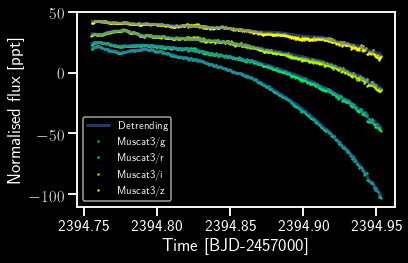

In [400]:
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter

plt.figure(figsize=(11,7))
rawfig,raw = plt.subplots()

for n,gd in enumerate('griz'):
    if n==0:
        raw.plot(alldata[gd+'_lco']['time'],n*12+np.nanmedian(trace["flux_cor_"+gd+'_lco'],axis=0),
                 '-',alpha=0.6,label="Detrending",color='C2',zorder=7,linewidth=3)
    else:
        raw.plot(alldata[gd+'_lco']['time'],n*12+np.nanmedian(trace["flux_cor_"+gd+'_lco'],axis=0),
                 '-',alpha=0.6,color='C2',zorder=7,linewidth=3)
    #plt.plot(alldata[gd+'_lco']['time'],n*8+soln['dfdairmass_'+gd+'_lco']*alldata[gd+'_lco']['airmass'])
    raw.plot(alldata[gd+'_lco']['time'],n*12+alldata[gd+'_lco']['flux'],
             '.',alpha=0.8,label="Muscat3/"+gd,color='C'+str(n+5),markersize=3)
    #plt.plot(alldata[gd+'_lco']['time'],alldata[gd+'_lco']['flux']-soln['dfdairmass_'+gd+'_lco']*alldata[gd+'_lco']['airmass'],'.',label=gd)
    #plt.plot(alldata[gd+'_lco']['time'],n*8+soln['dfdairmass_'+gd+'_lco']*alldata[gd+'_lco']['airmass']+soln['d2fdairmass2_'+gd+'_lco']*alldata[gd+'_lco']['airmass']**2,'.',label=gd)
raw.legend(fontsize=11,facecolor=None)
#raw.set_xticklabels([])
raw.set_ylabel("Normalised flux [ppt]")
raw.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
raw.set_xlabel("Time [BJD-2457000]")
plt.tight_layout()
rawfig.savefig("talk_raw_LCO_muscat_data.png",dpi=400,transparent=True)

<Figure size 792x504 with 0 Axes>

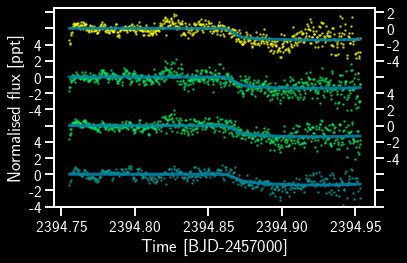

In [401]:
plt.figure(figsize=(11,7))
detfig,detrended = plt.subplots()
detrended2=detrended.twinx()

for n,gd in enumerate('griz'):
    #plt.plot(alldata[gd+'_lco']['time'],n*8+soln['dfdairmass_'+gd+'_lco']*alldata[gd+'_lco']['airmass'])
    if n%2==0:
        detrended2.plot(alldata[gd+'_lco']['time'],
                   n*6+alldata[gd+'_lco']['flux']-np.nanmedian(trace["flux_cor_"+gd+'_lco'],axis=0),
                   '.',alpha=0.6,label="LCO/Muscat3 "+gd,color='C'+str(n+4),markersize=3)
        detrended2.plot(alldata[gd+'_lco']['time'],
                 n*6+np.nanmedian(trace["planets_x_"+gd+'_lco'],axis=0),
                 '-',alpha=0.9,color='C3',linewidth=3)

    else:
        detrended.plot(alldata[gd+'_lco']['time'],
                   n*6+alldata[gd+'_lco']['flux']-np.nanmedian(trace["flux_cor_"+gd+'_lco'],axis=0),
                   '.',alpha=0.6,color='C'+str(n+5),markersize=3)
        detrended.plot(alldata[gd+'_lco']['time'],
                 n*6+np.nanmedian(trace["planets_x_"+gd+'_lco'],axis=0),
                 '-',alpha=0.9,color='C3',linewidth=3)

    #plt.plot(alldata[gd+'_lco']['time'],alldata[gd+'_lco']['flux']-soln['dfdairmass_'+gd+'_lco']*alldata[gd+'_lco']['airmass'],'.',label=gd)
    #plt.plot(alldata[gd+'_lco']['time'],n*8+soln['dfdairmass_'+gd+'_lco']*alldata[gd+'_lco']['airmass']+soln['d2fdairmass2_'+gd+'_lco']*alldata[gd+'_lco']['airmass']**2,'.',label=gd)
detrended.set_yticks(np.arange(-4,21,2))
detrended2.set_yticks(np.arange(-4,21,2))
detrended.set_ylim(-4,20.5)
detrended2.set_ylim(-4,20.5)

detrended.set_yticklabels(list(np.arange(-4,5,2).astype(str))+['']+list(np.arange(-4,5,2).astype(str))+['',''])
detrended2.set_yticklabels(['','','']+list(np.arange(-4,5,2).astype(str))+['']+list(np.arange(-4,3,2).astype(str)))

detrended.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

detrended.set_xlabel("Time [BJD-2457000]")
detrended.set_ylabel("Normalised flux [ppt]")
plt.tight_layout()
detfig.savefig("talk_det_LCO_muscat_data.png",transparent=True,dpi=400)

In [228]:
monotools_out=pd.read_csv("/Volumes/LUVOIR/MonoToolsData/TIC00027491137/TIC00027491137_2021-11-19_0_mcmc_output_short.csv",index_col=0)

In [246]:
clogprobs=np.array([monotools_out.loc["logprob_c["+str(n)+"]",'mean'] for n in range(7)])/np.log(10)
dlogprobs=np.array([monotools_out.loc["logprob_d["+str(n)+"]",'mean'] for n in range(11)])/np.log(10)
cpers=np.array([monotools_out.loc["per_c["+str(n)+"]",'mean'] for n in range(7)])
dpers=np.array([monotools_out.loc["per_d["+str(n)+"]",'mean'] for n in range(11)])

[-61.77817672 -27.26232672 -12.11949672  -4.86490672  -1.63512672
  -0.68040672  -1.23462672]


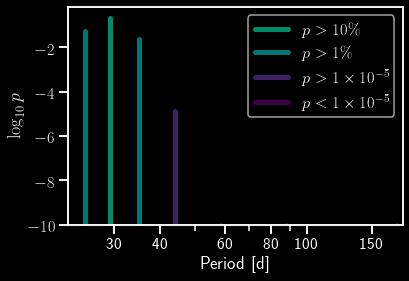

In [274]:
plt.figure(figsize=(5.5,7))
from scipy.special import logsumexp
probs=clogprobs - logsumexp(clogprobs)
print(probs)
pers = cpers
pmax = np.nanmax(pers)*1.03
pmin = np.nanmin(pers)*0.9
ymin = -10
xlog = True
#ymin = np.min(probs[pers<pmax])-0.5 if ymin is None else ymin
ymax = np.max(probs[pers<pmax])+0.5# if ymax is None else ymax
#psum=logsumexp(np.nanmedian(self.trace['logprob_marg_'+pl],axis=0))/np.log(10)
#Plotting lines
cols=[]
#plt.plot(pers,prob_prcnts[0,:],":",color='C0',alpha=0.65)
#plt.plot(pers,prob_prcnts[2,:],":",color='C0',alpha=0.65)
ordered_prob_index=np.arange(len(probs))[np.argsort(probs)][::-1]
coldic={-6:"$p<1\\times10^{-5}$",-5:"$p>1\\times10^{-5}$",-4:"$p>1\\times10^{-4}$",-3:"$p>0.1\%$",
        -2:"$p>1\%$",-1:"$p>10\%$",0:"$p>100\%$"}
for n in ordered_prob_index:
    # Density Plot and Histogram of all arrival delays
    #nprob=probs[n]
    ncol=int(np.floor(np.clip(probs[n],-6,0)))
    if ncol not in cols:
        cols+=[ncol]
        plt.plot(np.tile(pers[n],2),
                     [ymin,probs[n]],
                     linewidth=5.0,color=sns.color_palette()[6+ncol],alpha=0.7,label=coldic[ncol])
    else:
        plt.plot(np.tile(pers[n],2),
                     [ymin,probs[n]],
                     linewidth=5.0,color=sns.color_palette()[6+ncol],alpha=0.7)
plt.ylim(ymin,ymax)
plt.legend()
if xlog:
    plt.xscale('log')
    plt.xticks([20,30,40,60,80,100,150,200,250,300,350,400,450,500,600,700],
               np.array([20,30,40,60,80,100,150,200,250,300,350,400,450,500,600,700]).astype(str))
    #plt.xticklabels([20,40,60,80,100,150,200,250])
plt.ylabel("$\log_{10}{p}$")
plt.xlabel("Period [d]")
plt.xlim(pmin,pmax+1)
plt.savefig("talk_prob_d.png",transparent=True,dpi=400)

[-82.22739917 -44.30953917 -25.02605917 -14.03291917  -7.54496917
  -3.78685917  -1.85817917  -1.27405917  -1.32389917  -1.45878917
  -3.15730917]


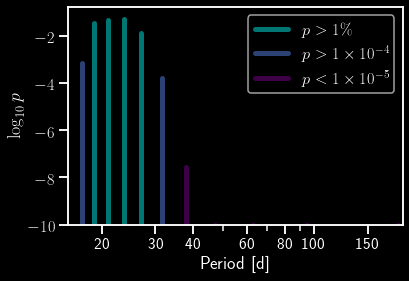

In [273]:
plt.figure(figsize=(5.5,7))
from scipy.special import logsumexp
probs=dlogprobs - logsumexp(dlogprobs)
print(probs)
pers = dpers
pmax = np.nanmax(pers)*1.03
pmin = np.nanmin(pers)*0.9
ymin = -10
xlog = True
#ymin = np.min(probs[pers<pmax])-0.5 if ymin is None else ymin
ymax = np.max(probs[pers<pmax])+0.5# if ymax is None else ymax
#psum=logsumexp(np.nanmedian(self.trace['logprob_marg_'+pl],axis=0))/np.log(10)
#Plotting lines
cols=[]
#plt.plot(pers,prob_prcnts[0,:],":",color='C0',alpha=0.65)
#plt.plot(pers,prob_prcnts[2,:],":",color='C0',alpha=0.65)
ordered_prob_index=np.arange(len(probs))[np.argsort(probs)][::-1]
coldic={-6:"$p<1\\times10^{-5}$",-5:"$p>1\\times10^{-5}$",-4:"$p>1\\times10^{-4}$",-3:"$p>0.1\%$",
        -2:"$p>1\%$",-1:"$p>10\%$",0:"$p>100\%$"}
for n in ordered_prob_index:
    # Density Plot and Histogram of all arrival delays
    #nprob=probs[n]
    ncol=int(np.floor(np.clip(probs[n],-6,0)))
    if ncol not in cols:
        cols+=[ncol]
        plt.plot(np.tile(pers[n],2),
                     [ymin,probs[n]],
                     linewidth=5.0,color=sns.color_palette()[6+ncol],alpha=0.7,label=coldic[ncol])
    else:
        plt.plot(np.tile(pers[n],2),
                     [ymin,probs[n]],
                     linewidth=5.0,color=sns.color_palette()[6+ncol],alpha=0.7)
plt.ylim(ymin,ymax)
plt.legend()
if xlog:
    plt.xscale('log')
    plt.xticks([20,30,40,60,80,100,150,200,250,300,350,400,450,500,600,700],
               np.array([20,30,40,60,80,100,150,200,250,300,350,400,450,500,600,700]).astype(str))
    #plt.xticklabels([20,40,60,80,100,150,200,250])
plt.ylabel("$\log_{10}{p}$")
plt.xlabel("Period [d]")
plt.xlim(pmin,pmax+1)
plt.savefig("talk_prob_c.png",transparent=True,dpi=400)

[-82.22739917 -44.30953917 -25.02605917 -14.03291917  -7.54496917
  -3.78685917  -1.85817917  -1.27405917  -1.32389917  -1.45878917
  -3.15730917]
[-61.77817672 -27.26232672 -12.11949672  -4.86490672  -1.63512672
  -0.68040672  -1.23462672]


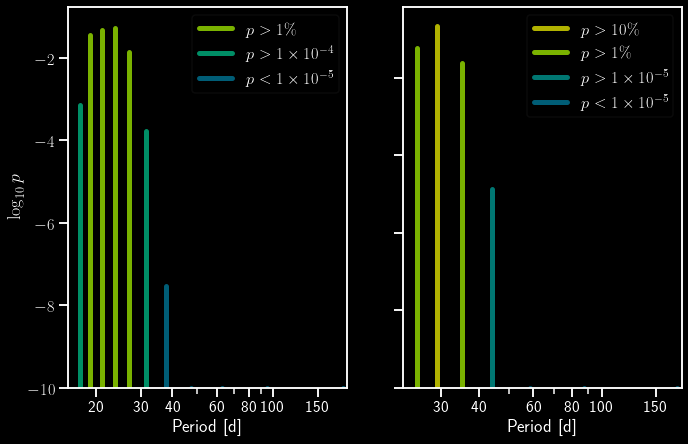

In [281]:
plt.figure(figsize=(11,7))
from scipy.special import logsumexp
plt.subplot(121)
probs=dlogprobs - logsumexp(dlogprobs)
print(probs)
pers = dpers
pmax = np.nanmax(pers)*1.03
pmin = np.nanmin(pers)*0.9
ymin = -10
xlog = True
#ymin = np.min(probs[pers<pmax])-0.5 if ymin is None else ymin
ymax = np.max(probs[pers<pmax])+0.5# if ymax is None else ymax
#psum=logsumexp(np.nanmedian(self.trace['logprob_marg_'+pl],axis=0))/np.log(10)
#Plotting lines
cols=[]
#plt.plot(pers,prob_prcnts[0,:],":",color='C0',alpha=0.65)
#plt.plot(pers,prob_prcnts[2,:],":",color='C0',alpha=0.65)
ordered_prob_index=np.arange(len(probs))[np.argsort(probs)][::-1]
coldic={-6:"$p<1\\times10^{-5}$",-5:"$p>1\\times10^{-5}$",-4:"$p>1\\times10^{-4}$",-3:"$p>0.1\%$",
        -2:"$p>1\%$",-1:"$p>10\%$",0:"$p>100\%$"}
for n in ordered_prob_index:
    # Density Plot and Histogram of all arrival delays
    #nprob=probs[n]
    ncol=int(np.floor(np.clip(probs[n],-6,0)))
    if ncol not in cols:
        cols+=[ncol]
        plt.plot(np.tile(pers[n],2),
                     [ymin,probs[n]],
                     linewidth=5.0,color=sns.color_palette()[9+ncol],alpha=0.7,label=coldic[ncol])
    else:
        plt.plot(np.tile(pers[n],2),
                     [ymin,probs[n]],
                     linewidth=5.0,color=sns.color_palette()[9+ncol],alpha=0.7)
plt.ylim(ymin,ymax)
plt.legend(facecolor=None,framealpha=0.05)
if xlog:
    plt.xscale('log')
    plt.xticks([20,30,40,60,80,100,150,200,250,300,350,400,450,500,600,700],
               np.array([20,30,40,60,80,100,150,200,250,300,350,400,450,500,600,700]).astype(str))
    #plt.xticklabels([20,40,60,80,100,150,200,250])
plt.ylabel("$\log_{10}{p}$")
plt.xlabel("Period [d]")
plt.xlim(pmin,pmax+1)

plt.subplot(122)
probs=clogprobs - logsumexp(clogprobs)
print(probs)
pers = cpers
pmax = np.nanmax(pers)*1.03
pmin = np.nanmin(pers)*0.9
ymin = -10
xlog = True
#ymin = np.min(probs[pers<pmax])-0.5 if ymin is None else ymin
ymax = np.max(probs[pers<pmax])+0.5# if ymax is None else ymax
#psum=logsumexp(np.nanmedian(self.trace['logprob_marg_'+pl],axis=0))/np.log(10)
#Plotting lines
cols=[]
#plt.plot(pers,prob_prcnts[0,:],":",color='C0',alpha=0.65)
#plt.plot(pers,prob_prcnts[2,:],":",color='C0',alpha=0.65)
ordered_prob_index=np.arange(len(probs))[np.argsort(probs)][::-1]
coldic={-6:"$p<1\\times10^{-5}$",-5:"$p>1\\times10^{-5}$",-4:"$p>1\\times10^{-4}$",-3:"$p>0.1\%$",
        -2:"$p>1\%$",-1:"$p>10\%$",0:"$p>100\%$"}
for n in ordered_prob_index:
    # Density Plot and Histogram of all arrival delays
    #nprob=probs[n]
    ncol=int(np.floor(np.clip(probs[n],-6,0)))
    if ncol not in cols:
        cols+=[ncol]
        plt.plot(np.tile(pers[n],2),
                     [ymin,probs[n]],
                     linewidth=5.0,color=sns.color_palette()[9+ncol],alpha=0.7,label=coldic[ncol])
    else:
        plt.plot(np.tile(pers[n],2),
                     [ymin,probs[n]],
                     linewidth=5.0,color=sns.color_palette()[9+ncol],alpha=0.7)
plt.ylim(ymin,ymax)
plt.legend(facecolor=None,framealpha=0.05)
if xlog:
    plt.xscale('log')
    plt.xticks([20,30,40,60,80,100,150,200,250,300,350,400,450,500,600,700],
               np.array([20,30,40,60,80,100,150,200,250,300,350,400,450,500,600,700]).astype(str))
    #plt.xticklabels([20,40,60,80,100,150,200,250])
#plt.ylabel("$\log_{10}{p}$")
plt.gca().set_yticklabels([])
plt.xlabel("Period [d]")
plt.xlim(pmin,pmax+1)

plt.savefig("talk_prob_both.png",transparent=True,dpi=400)

In [310]:
monotools_out2=pd.read_csv("/Volumes/LUVOIR/MonoToolsData/TIC00027491137/TIC00027491137_2021-11-19_1_mcmc_output_short.csv",index_col=0)

In [312]:
monotools_out2.index

Index(['Rs[0]', 'per_b', 'per_c', 'logs2[0]', 'logs2[1]', 'phot_mean', 'rho_S',
       'Ms[0]', 't0_b', 'logror_b',
       ...
       'logprob_d[1]', 'logprob_d[2]', 'logprob_d[3]', 'logprob_d[4]',
       'logprob_d[5]', 'logprob_d[6]', 'ecc_d', 'ecc_marg_d', 'vel_marg_d',
       'per_marg_d'],
      dtype='object', length=130)

[-25.97959701 -10.81508035  -4.11314779  -0.9018441   -0.55760058
  -5.25490799 -24.071585  ]


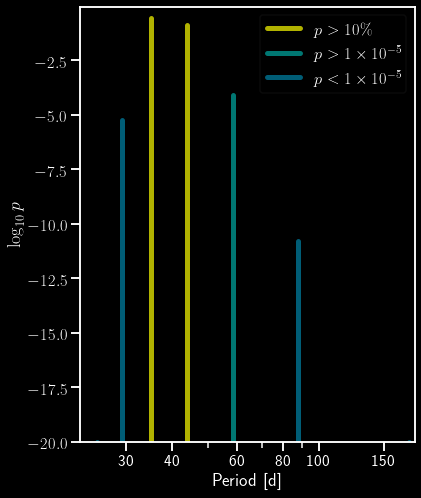

In [315]:
dlogprobs=np.array([monotools_out2.loc["logprob_d["+str(n)+"]",'mean'] for n in range(7)])/np.log(10)
dpers=np.array([monotools_out2.loc["per_d["+str(n)+"]",'mean'] for n in range(7)])

plt.figure(figsize=(6,8))
from scipy.special import logsumexp
probs=dlogprobs - logsumexp(dlogprobs)
print(probs)
pers = dpers
pmax = np.nanmax(pers)*1.03
pmin = np.nanmin(pers)*0.9
ymin = -20
xlog = True
#ymin = np.min(probs[pers<pmax])-0.5 if ymin is None else ymin
ymax = np.max(probs[pers<pmax])+0.5# if ymax is None else ymax
#psum=logsumexp(np.nanmedian(self.trace['logprob_marg_'+pl],axis=0))/np.log(10)
#Plotting lines
cols=[]
#plt.plot(pers,prob_prcnts[0,:],":",color='C0',alpha=0.65)
#plt.plot(pers,prob_prcnts[2,:],":",color='C0',alpha=0.65)
ordered_prob_index=np.arange(len(probs))[np.argsort(probs)][::-1]
coldic={-6:"$p<1\\times10^{-5}$",-5:"$p>1\\times10^{-5}$",-4:"$p>1\\times10^{-4}$",-3:"$p>0.1\%$",
        -2:"$p>1\%$",-1:"$p>10\%$",0:"$p>100\%$"}
for n in ordered_prob_index:
    # Density Plot and Histogram of all arrival delays
    #nprob=probs[n]
    ncol=int(np.floor(np.clip(probs[n],-6,0)))
    if ncol not in cols:
        cols+=[ncol]
        plt.plot(np.tile(pers[n],2),
                     [ymin,probs[n]],
                     linewidth=5.0,color=sns.color_palette()[9+ncol],alpha=0.7,label=coldic[ncol])
    else:
        plt.plot(np.tile(pers[n],2),
                     [ymin,probs[n]],
                     linewidth=5.0,color=sns.color_palette()[9+ncol],alpha=0.7)
plt.ylim(ymin,ymax)
plt.legend(facecolor=None,framealpha=0.05)
if xlog:
    plt.xscale('log')
    plt.xticks([20,30,40,60,80,100,150,200,250,300,350,400,450,500,600,700],
               np.array([20,30,40,60,80,100,150,200,250,300,350,400,450,500,600,700]).astype(str))
    #plt.xticklabels([20,40,60,80,100,150,200,250])
plt.ylabel("$\log_{10}{p}$")
plt.xlabel("Period [d]")
plt.xlim(pmin,pmax+1)

plt.savefig("talk_prob_post_c_det.png",transparent=True,dpi=400)

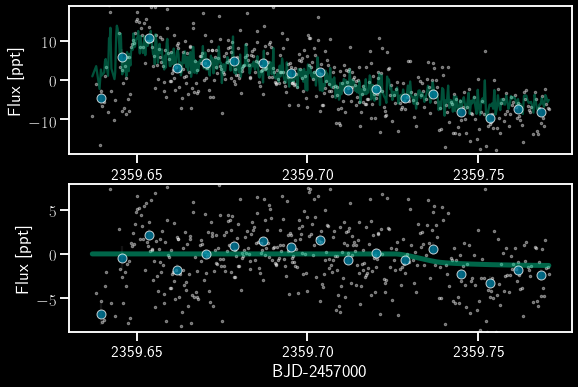

In [398]:
plt.figure(figsize=(9,6))
binsize=1/(24*5)
saintex = plt.subplot(211)

saintex.plot(alldata['r_sex']['time'],alldata['r_sex']['flux'],
             '.w',alpha=0.4,label="SaintEx/"+gd,markersize=5)
binlc=tools.bin_lc_segment(np.column_stack((alldata['r_sex']['time'],alldata['r_sex']['flux'],
                                            alldata['r_sex']['flux_err'])),binsize)
saintex.plot(alldata['r_sex']['time'],np.nanmedian(trace["flux_cor_r_sex"],axis=0),
         '-',alpha=0.4,label="Detrending",color='C5')
saintex.errorbar(binlc[:,0],binlc[:,1],yerr=binlc[:,2],
                 fmt='o',markeredgecolor='w',markersize=9,alpha=0.75,color='C3',ecolor='k')


saintex.set_xticklabels([])
saintex.set_ylim(-19,19)
saintex.xaxis.set_ticks(np.arange(2359.65,2359.79,0.05))
saintex.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
saintex.set_ylabel("Flux [ppt]")
#saintexraw.set_ylabel("Normalised flux [ppt]")
saintex2 = plt.subplot(212)

saintex2.plot(alldata['r_sex']['time'],
           alldata['r_sex']['flux']-np.nanmedian(trace["flux_cor_r_sex"],axis=0),
           '.',c='w',alpha=0.4,markersize=5)
saintex2.plot(alldata['r_sex']['time'],
         np.nanmedian(trace["planets_x_r_sex"],axis=0),
         '-',alpha=0.5,color='C5',linewidth=5)
binlc=tools.bin_lc_segment(np.column_stack((alldata['r_sex']['time'],
                                            alldata['r_sex']['flux']-np.nanmedian(trace["flux_cor_r_sex"],axis=0),
                                            alldata['r_sex']['flux_err'])),binsize)
saintex2.errorbar(binlc[:,0],binlc[:,1],yerr=binlc[:,2],
                       fmt='o',markeredgecolor='w',markersize=9,alpha=0.75,color='C3',ecolor='k',zorder=2)

saintex2.set_xlabel("BJD-2457000")
#saintexdetrended.set_ylabel("Normalised flux [ppt]")
saintex2.set_ylim(-9,8)
saintex2.xaxis.set_ticks(np.arange(2359.65,2359.79,0.05))
saintex2.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
saintex2.set_ylabel("Flux [ppt]")

plt.savefig('talk_saintex.png',transparent=True,dpi=400)

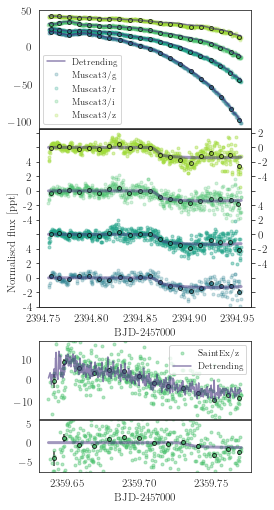

In [9]:
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter

binsize=15/1440

fig=plt.figure(figsize=(3.8,8.5))
gs = gridspec.GridSpec(ncols=1, nrows=70, figure=fig)
lcoraw = fig.add_subplot(gs[:18, :])
lcodetrended = fig.add_subplot(gs[18:45, :])
saintexraw = fig.add_subplot(gs[50:62, :])
saintexdetrended = fig.add_subplot(gs[62:, :])

for n,gd in enumerate('griz'):
    binlc=tools.bin_lc_segment(np.column_stack((alldata[gd+'_lco']['time'],
                                                n*12+alldata[gd+'_lco']['flux'],
                                                alldata[gd+'_lco']['flux_err'])),binsize)
    if n==0:
        lcoraw.plot(alldata[gd+'_lco']['time'],n*12+np.nanmedian(trace["flux_cor_"+gd+'_lco'],axis=0),
                 '-',alpha=0.6,label="Detrending",color='C0',zorder=2)
    else:
        lcoraw.plot(alldata[gd+'_lco']['time'],n*12+np.nanmedian(trace["flux_cor_"+gd+'_lco'],axis=0),
                 '-',alpha=0.6,color='C0',zorder=2)
    #plt.plot(alldata[gd+'_lco']['time'],n*8+soln['dfdairmass_'+gd+'_lco']*alldata[gd+'_lco']['airmass'])
    lcoraw.plot(alldata[gd+'_lco']['time'],n*12+alldata[gd+'_lco']['flux'],
             '.',alpha=0.24,label="Muscat3/"+gd,color='C'+str(n+2),zorder=0)
    lcoraw.errorbar(binlc[:,0],binlc[:,1],yerr=binlc[:,2],
                    fmt='o',markeredgecolor='k',markersize=4,alpha=0.75,color='C'+str(n+2),ecolor='k',zorder=1)

    #plt.plot(alldata[gd+'_lco']['time'],alldata[gd+'_lco']['flux']-soln['dfdairmass_'+gd+'_lco']*alldata[gd+'_lco']['airmass'],'.',label=gd)
    #plt.plot(alldata[gd+'_lco']['time'],n*8+soln['dfdairmass_'+gd+'_lco']*alldata[gd+'_lco']['airmass']+soln['d2fdairmass2_'+gd+'_lco']*alldata[gd+'_lco']['airmass']**2,'.',label=gd)
lcoraw.legend(fontsize=9)
lcoraw.set_xticklabels([])
#lcoraw.set_ylabel("Normalised flux [ppt]")

lcodetrended2=lcodetrended.twinx()

for n,gd in enumerate('griz'):
    #plt.plot(alldata[gd+'_lco']['time'],n*8+soln['dfdairmass_'+gd+'_lco']*alldata[gd+'_lco']['airmass'])
    binlc=tools.bin_lc_segment(np.column_stack((alldata[gd+'_lco']['time'],
                                                n*6+alldata[gd+'_lco']['flux']-np.nanmedian(trace["flux_cor_"+gd+'_lco'],axis=0),
                                                alldata[gd+'_lco']['flux_err'])),binsize)
    if n%2==0:
        lcodetrended2.plot(alldata[gd+'_lco']['time'],
                   n*6+alldata[gd+'_lco']['flux']-np.nanmedian(trace["flux_cor_"+gd+'_lco'],axis=0),
                   '.',alpha=0.24,label="LCO/Muscat3 "+gd,color='C'+str(n+2),zorder=0)
        lcodetrended2.plot(alldata[gd+'_lco']['time'],
                 n*6+np.nanmedian(trace["planets_x_"+gd+'_lco'],axis=0),
                 '-',alpha=0.5,color='C0',linewidth=3,zorder=3)
        lcodetrended2.errorbar(binlc[:,0],binlc[:,1],yerr=binlc[:,2],
                               fmt='o',markeredgecolor='k',markersize=4,alpha=0.75,color='C'+str(n+2),ecolor='k',zorder=2)
    else:
        lcodetrended.plot(alldata[gd+'_lco']['time'],
                   n*6+alldata[gd+'_lco']['flux']-np.nanmedian(trace["flux_cor_"+gd+'_lco'],axis=0),
                   '.',alpha=0.4,color='C'+str(n+2),zorder=1)
        lcodetrended.plot(alldata[gd+'_lco']['time'],
                 n*6+np.nanmedian(trace["planets_x_"+gd+'_lco'],axis=0),
                 '-',alpha=0.5,color='C0',linewidth=3,zorder=2)
        lcodetrended.errorbar(binlc[:,0],binlc[:,1],yerr=binlc[:,2],
                               fmt='o',markeredgecolor='k',markersize=4,alpha=0.75,color='C'+str(n+2),ecolor='k',zorder=2)

    #plt.plot(alldata[gd+'_lco']['time'],alldata[gd+'_lco']['flux']-soln['dfdairmass_'+gd+'_lco']*alldata[gd+'_lco']['airmass'],'.',label=gd)
    #plt.plot(alldata[gd+'_lco']['time'],n*8+soln['dfdairmass_'+gd+'_lco']*alldata[gd+'_lco']['airmass']+soln['d2fdairmass2_'+gd+'_lco']*alldata[gd+'_lco']['airmass']**2,'.',label=gd)
lcodetrended.set_yticks(np.arange(-4,21,2))
lcodetrended2.set_yticks(np.arange(-4,21,2))
lcodetrended.set_ylim(-4,20.5)
lcodetrended2.set_ylim(-4,20.5)

lcodetrended.set_yticklabels(list(np.arange(-4,5,2).astype(str))+['']+list(np.arange(-4,5,2).astype(str))+['',''])
lcodetrended2.set_yticklabels(['','','']+list(np.arange(-4,5,2).astype(str))+['']+list(np.arange(-4,3,2).astype(str)))

lcodetrended.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

lcodetrended.set_xlabel("BJD-2457000")
#lcodetrended.set_ylabel("Normalised flux [ppt]")

saintexraw.plot(alldata['r_sex']['time'],alldata['r_sex']['flux'],
             '.',alpha=0.4,label="SaintEx/"+gd,color='C'+str(2+2))
binlc=tools.bin_lc_segment(np.column_stack((alldata['r_sex']['time'],alldata['r_sex']['flux'],
                                            alldata['r_sex']['flux_err'])),binsize)
saintexraw.errorbar(binlc[:,0],binlc[:,1],yerr=binlc[:,2],
                       fmt='o',markeredgecolor='k',markersize=4,alpha=0.75,color='C'+str(2+2),ecolor='k',zorder=2)

saintexraw.plot(alldata['r_sex']['time'],np.nanmedian(trace["flux_cor_r_sex"],axis=0),
         '-',alpha=0.6,label="Detrending",color='C0',zorder=7)

saintexraw.legend(fontsize=9)
saintexraw.set_xticklabels([])
saintexraw.set_ylim(-19,19)
#saintexraw.set_ylabel("Normalised flux [ppt]")

saintexdetrended.plot(alldata['r_sex']['time'],
           alldata['r_sex']['flux']-np.nanmedian(trace["flux_cor_r_sex"],axis=0),
           '.',alpha=0.4,color='C'+str(2+2))
saintexdetrended.plot(alldata['r_sex']['time'],
         np.nanmedian(trace["planets_x_r_sex"],axis=0),
         '-',alpha=0.5,color='C0',linewidth=3)
binlc=tools.bin_lc_segment(np.column_stack((alldata['r_sex']['time'],
                                            alldata['r_sex']['flux']-np.nanmedian(trace["flux_cor_r_sex"],axis=0),
                                            alldata['r_sex']['flux_err'])),binsize)
saintexdetrended.errorbar(binlc[:,0],binlc[:,1],yerr=binlc[:,2],
                       fmt='o',markeredgecolor='k',markersize=4,alpha=0.75,color='C'+str(2+2),ecolor='k',zorder=2)

saintexdetrended.set_xlabel("BJD-2457000")
#saintexdetrended.set_ylabel("Normalised flux [ppt]")
saintexdetrended.set_ylim(-8,6)
saintexdetrended.xaxis.set_ticks(np.arange(2359.65,2359.79,0.05))
saintexraw.xaxis.set_ticks(np.arange(2359.65,2359.79,0.05))
saintexdetrended.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

fig.text(0.01, 0.5, 'Normalised flux [ppt]', va='center', rotation='vertical')

fig.savefig("TOI-2076CheopsPaper/ground_35d_data2.pdf")


In [5]:
def vals_to_latex(vals):
    #Function to turn -1,0, and +1 sigma values into round latex strings for a table
    try:
        roundval=int(np.min([-1*np.floor(np.log10(abs(vals[1]-vals[0])))+1,-1*np.floor(np.log10(abs(vals[2]-vals[1])))+1]))
        errs=[vals[2]-vals[1],vals[1]-vals[0]]
        if np.round(errs[0],roundval-1)==np.round(errs[1],roundval-1):
            #Errors effectively the same...
            if roundval<0:
                return " $ "+str(int(np.round(vals[1],roundval)))+" \pm "+str(int(np.round(np.average(errs),roundval)))+" $ "
            else:
                return " $ "+str(np.round(vals[1],roundval))+" \pm "+str(np.round(np.average(errs),roundval))+" $ "
        else:
            if roundval<0:
                return " $ "+str(int(np.round(vals[1],roundval)))+"^{+"+str(int(np.round(errs[0],roundval)))+"}_{-"+str(int(np.round(errs[1],roundval)))+"} $ "
            else:
                return " $ "+str(np.round(vals[1],roundval))+"^{+"+str(np.round(errs[0],roundval))+"}_{-"+str(np.round(errs[1],roundval))+"} $ "
    except:
        return " - "

def vals_to_short(vals,roundval=None):
    #Function to turn -1,0, and +1 sigma values into round latex strings for a table
    try:
        if roundval is None:
            roundval=int(np.min([-1*np.floor(np.log10(abs(vals[1]-vals[0])))+1,-1*np.floor(np.log10(abs(vals[2]-vals[1])))+1]))-1
        return " $ "+str(np.round(vals[1],roundval))+" $ "
    except:
        return " - "
    
    
def vals_to_overleaf(name,vals,include_short=True):
    if len(vals)==2 and vals[1]<0.5*vals[0]:
        vals=[vals[0]-vals[1],vals[0],vals[0]+vals[1]]
    
    replace_vals = {'_':'','[':'',']':'','/':'div','-':'minus','0':'zero','1':'one','2':'two','3':'three','4':'four','5':'five','6':'six','7':'seven','8':'eight','9':'nine'}
    for symbol, text in replace_vals.items():
        name = name.replace(symbol, text)
    st = "\\newcommand{\\T"+name+"}{"+vals_to_latex(vals)+"}\n"
    if include_short:
        st+="\\newcommand{\\T"+name+"short}{"+vals_to_short(vals)+"}\n"
    return st

In [13]:
df=pm.summary(trace,[var for var in trace.varnames if '__' not in var and np.product(np.shape(trace[var]))<1.1*np.product(np.shape(trace['t0']))],
              stat_funcs={"5%": lambda x: np.percentile(x, 5),"-$1\sigma$": lambda x: np.percentile(x, 15.87),
                          "median": lambda x: np.percentile(x, 50),"+$1\sigma$": lambda x: np.percentile(x, 84.13),
                          "95%": lambda x: np.percentile(x, 95)},round_to=8)

/Users/hosborn/miniconda3/envs/newxo/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{true_div,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Join.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{0,x}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{true_div,no_inplace}.0
WARNING (theano.tensor.opt): Cannot

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Join.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{0,x}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{true_div,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Join.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{0,x}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{true_div,no_inplace}.0
WARNING (theano.tensor.opt): Canno

In [47]:
np.nanpercentile(oldtrace['transit_times_2'][:,2],[15.87,50,84.13]),np.nanpercentile(trace['transit_times_2'][:,2],[15.87,50,84.13])

(array([2359.76614262, 2359.78829322, 2359.80970702]),
 array([2394.92248612, 2394.92374554, 2394.92527285]))

In [8]:
strings=[]
allnames=[]
for name,row in df.iterrows():
    if 'log' in name:
        strings+=[vals_to_overleaf(name.replace('log',''),[np.exp(row[col]) for col in ['-$1\sigma$','median','+$1\sigma$']])]
        allnames+=[name.replace('log','')]
    if name not in allnames:
        strings+=[vals_to_overleaf(name,[row[col] for col in ['-$1\sigma$','median','+$1\sigma$']])]
        allnames+=[name]
#strings+=[vals_to_overleaf("transit_times_2[3]",np.nanpercentile(oldtrace['transit_times_2'][:,2],[15.87,50,84.13]))]
allnames+=["transit_times_2[3]"]
from datetime import datetime
with open("TOI-2076CheopsPaper/FileOutput"+datetime.now().strftime("%Y%m%d%H")+".tex","wb") as filez:
    for line in strings:
        filez.write((line+"\n").encode())

In [9]:
"TOI-2076CheopsPaper/FileOutput"+datetime.now().strftime("%Y%m%d%H")+".tex"

'TOI-2076CheopsPaper/FileOutput2021120610.tex'

In [44]:
strings

['\\newcommand{\\Tg}{ $ 97.0^{+1.2}_{-2.0} $ }\n\\newcommand{\\Tgshort}{ $ 97.0 $ }\n',
 '\\newcommand{\\Tlogg}{ $ 4.575^{+0.012}_{-0.021} $ }\n\\newcommand{\\Tloggshort}{ $ 4.57 $ }\n',
 '\\newcommand{\\Ttransittimeszerozero}{ $ 1743.7195 \\pm 0.0023 $ }\n\\newcommand{\\Ttransittimeszerozeroshort}{ $ 1743.719 $ }\n',
 '\\newcommand{\\Ttransittimeszeroone}{ $ 1754.0777 \\pm 0.0013 $ }\n\\newcommand{\\Ttransittimeszerooneshort}{ $ 1754.078 $ }\n',
 '\\newcommand{\\Ttransittimeszerotwo}{ $ 1930.1228 \\pm 0.002 $ }\n\\newcommand{\\Ttransittimeszerotwoshort}{ $ 1930.123 $ }\n',
 '\\newcommand{\\Ttransittimeszerothree}{ $ 1940.4801 \\pm 0.001 $ }\n\\newcommand{\\Ttransittimeszerothreeshort}{ $ 1940.48 $ }\n',
 '\\newcommand{\\Ttransittimeszerofour}{ $ 1950.8345 \\pm 0.0012 $ }\n\\newcommand{\\Ttransittimeszerofourshort}{ $ 1950.835 $ }\n',
 '\\newcommand{\\Ttransittimeszerofive}{ $ 2333.957^{+0.0022}_{-0.0026} $ }\n\\newcommand{\\Ttransittimeszerofiveshort}{ $ 2333.957 $ }\n',
 '\\newcomman

In [95]:
np.nanmedian(trace['transit_times_1'][:,1]-trace['transit_times_1'][:,0])/11

17.19344464453404

In [324]:
cutDistance = 2.5
#all_scopes
#from MonoTools.MonoTools import lightcurve,tools
#lc=lightcurve.multilc(4646810,'tess',load=True)
past_modelling=pd.read_csv('/Volumes/LUVOIR/Cheops_data/TOI2076/CombModelOutputs/TOI2076_finalmodel_P35_circ_ncbaenwgr_na_nogp_nocontam_fixld_add_parameter_groups_pmxsample_20211125_results.csv',index_col=0)
#"/Volumes/LUVOIR/MonoToolsData/TIC00027491137/TIC00027491137_2021-06-29_1_mcmc_output_short.csv",index_col=0)

alldata['tess']['in_trans']   = np.tile(False,len(alldata['tess']['time']))
alldata['tess']['near_trans'] = np.tile(False,len(alldata['tess']['time']))
for nfk in range(4):
    alldata['cheops_'+str(nfk)]['in_trans'] = np.tile(False,len(alldata['cheops_'+str(nfk)]['time']))

init_transit_times={}
init_transit_inds={}
info={}
p=35

for pl in range(3):
    info[pl]={}
    info[pl]['t0']=past_modelling.loc['t0['+str(pl)+']','mean']
    if pl==0:
        info[pl]['p']=past_modelling.loc['derived_period['+str(pl)+']','mean']
    elif pl==1:
        info[pl]['p']=past_modelling.loc['derived_period['+str(pl)+']','mean']
    else:
        if p==25:
            info[pl]['p']=(1938.2899096646295-1762.6651396199247)/7
        elif p==35:
            info[pl]['p']=past_modelling.loc['derived_period['+str(pl)+']','mean']
        elif p==88:
            info[pl]['p']=(1938.2899096646295-1762.6651396199247)/2
    info[pl]['dur'] = np.random.normal(past_modelling.loc['tdur['+str(pl)+']','mean'],
                                       2.5*past_modelling.loc['tdur['+str(pl)+']','sd'])/24
    tess_phase=abs((alldata['tess']['time']-info[pl]['t0']-0.5*info[pl]['p'])%info[pl]['p']-0.5*info[pl]['p'])
    alldata['tess']['in_trans']+=tess_phase<0.55*info[pl]['dur']
    alldata['tess']['near_trans']+=tess_phase<cutDistance*info[pl]['dur']
    for nfk in range(4):
        cheops_phase=abs((alldata['cheops_'+str(nfk)]['time']-info[pl]['t0']-0.5*info[pl]['p'])%info[pl]['p']-0.5*info[pl]['p'])
        alldata['cheops_'+str(nfk)]['in_trans']+=abs(cheops_phase)<0.55*info[pl]['dur']
    
    # Getting the transit time centres:
    tcens=info[pl]['t0']+np.arange(-100,150)*info[pl]['p']
    #ix=np.min(abs(tcens[:,None]-np.hstack([alldata[scope]['time'] for scope in all_scopes])[None,:]),axis=1)<info[pl]['dur']*0.65
    #init_transit_times[pl]=tcens[ix]
    #init_transit_inds[pl]=np.arange(-100,150)[ix]
    #init_transit_inds[pl]-=np.min(init_transit_inds[pl])
    '''info[pl]={}
    info[pl]['t0']=np.random.normal(past_modelling.loc['t0['+str(pl)+']','mean'],
                                    2.5*past_modelling.loc['t0['+str(pl)+']','sd'])
    if pl==0:
        info[pl]['p']=np.random.normal(past_modelling.loc['derived_period['+str(pl)+']','mean'],
                                       2.5*past_modelling.loc['derived_period['+str(pl)+']','sd'])
    elif pl==1:
        info[pl]['p']=np.random.normal(past_modelling.loc['derived_period['+str(pl)+']','mean'],
                                       2.5*past_modelling.loc['derived_period['+str(pl)+']','sd'])
    else:
        if 'P25' in filename:
            info[pl]['p']=(1938.2899096646295-1762.6651396199247)/7
        elif 'P35' in filename:
            info[pl]['p']=np.random.normal(past_modelling.loc['derived_period['+str(pl)+']','mean'],
                                           2.5*past_modelling.loc['derived_period['+str(pl)+']','sd'])
        elif 'P88' in filename:
            info[pl]['p']=(1938.2899096646295-1762.6651396199247)/2
    info[pl]['dur'] = np.random.normal(past_modelling.loc['tdur['+str(pl)+']','mean'],
                                       2.5*past_modelling.loc['tdur['+str(pl)+']','sd'])/24
    
    tess_phase=abs((alldata['tess']['time']-info[pl]['t0']-0.5*info[pl]['p'])%info[pl]['p']-0.5*info[pl]['p'])
    alldata['tess']['in_trans']+=tess_phase<0.55*info[pl]['dur']
    alldata['tess']['near_trans']+=tess_phase<cutDistance*info[pl]['dur']
    for nfk in range(4):
        cheops_phase=abs((alldata['cheops_'+str(nfk)]['time']-info[pl]['t0']-0.5*info[pl]['p'])%info[pl]['p']-0.5*info[pl]['p'])
        alldata['cheops_'+str(nfk)]['in_trans']+=abs(cheops_phase)<0.55*info[pl]['dur']
    
    # Getting the transit time centres:
    tcens=info[pl]['t0']+np.arange(-100,150)*info[pl]['p']
    #ix=np.min(abs(tcens[:,None]-np.hstack([alldata[scope]['time'] for scope in all_scopes])[None,:]),axis=1)<info[pl]['dur']*0.55
    #init_transit_times[pl]=tcens[ix]
    #init_transit_inds[pl]=np.arange(-100,150)[ix]
    #init_transit_inds[pl]-=np.min(init_transit_inds[pl])
'''

from MonoTools.MonoTools import tools

lcdic={'time':np.array(list(alldata['tess']['time'][:])),
       'flux':np.array(list(alldata['tess']['flux'][:])),
       'flux_err':np.array(list(alldata['tess']['flux_err'][:])),
       'flux_unit':1}
print(np.nanstd(lcdic['flux']),np.nanmedian(lcdic['flux']),np.nanstd(lcdic['flux_err']),np.nanmedian(lcdic['flux_err']))
lcdic['mask']=tools.maskLc(lcdic,'')
print(np.nanstd(lcdic['flux']),np.nanmedian(lcdic['flux']),np.nanstd(lcdic['flux_err']),np.nanmedian(lcdic['flux_err']))
#lcdic['flux']=lcdic['flux']-0.001
#lcdic['flux_err']/=1e6

mod,_=tools.kepler_spline(alldata['tess']['time'][:],alldata['tess']['flux'][:],
                    flux_mask=lcdic['mask'],
                    transit_mask=~alldata['tess']['in_trans'][:])
#lcdic=tools.lcFlatten(lcdic, transit_mask=~alldata['tess']['in_trans'][:])#['spline']
alldata['tess']['flux_flat']=alldata['tess']['flux']-mod
alldata['tess']['mask']=lcdic['mask']

alldata['tess']['modtime']     = alldata['tess']['time'][alldata['tess']['mask']&alldata['tess']['near_trans']]
alldata['tess']['modflux']     = alldata['tess']['flux'][alldata['tess']['mask']&alldata['tess']['near_trans']]
alldata['tess']['modflux_err'] = alldata['tess']['flux_err'][alldata['tess']['mask']&alldata['tess']['near_trans']]

0.5666230382743256 0.0 0.04871965510449328 0.4168251864494
0.5666143923829033 -1.525863023266183e-05 0.048718911709290984 0.4168188262680083


IndexError: boolean index did not match indexed array along dimension 1; dimension is 4354 but corresponding boolean dimension is 4412

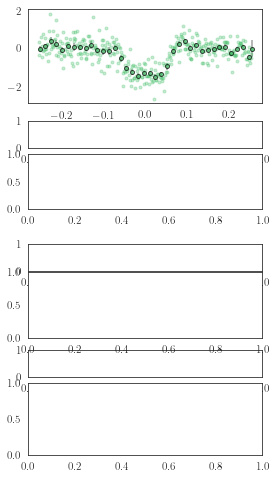

In [18]:
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter

fig=plt.figure(figsize=(4.2,8.2))
gs = gridspec.GridSpec(ncols=1, nrows=80, figure=fig)
tess_d=fig.add_subplot(gs[:17, :])
cheops12 = [[fig.add_subplot(gs[20:25, :]),fig.add_subplot(gs[26:36, :])],
            [fig.add_subplot(gs[61:66, :]),fig.add_subplot(gs[67:80, :])]]
lco3 = [fig.add_subplot(gs[42:47, :]),fig.add_subplot(gs[47:59, :])]

span=np.nanmedian(trace['transit_times_2'][:,1])-np.nanmedian(trace['transit_times_2'][:,0])
shifts=[span*(1+9/4),span*(1+14/6),span*(1+16/7)]
binsize=20/1440

for i in range(2):
    t0=np.nanmedian(trace['transit_times_2'][:,i])
    tess_d.plot(alldata['tess']['modtime'][abs(alldata['tess']['modtime']-t0)<0.255]-t0,
                i*3+alldata['tess']['modflux'][abs(alldata['tess']['modtime']-t0)<0.255],
                '.',color='C'+str(2+2),alpha=0.3)
    bin_tess=tools.bin_lc_segment(np.column_stack((alldata['tess']['modtime'][abs(alldata['tess']['modtime']-t0)<0.255]-t0,
                                          i*3+alldata['tess']['modflux'][abs(alldata['tess']['modtime']-t0)<0.255],
                                          i*3+alldata['tess']['modflux_err'][abs(alldata['tess']['modtime']-t0)<0.255])),binsize)
    tess_d.errorbar(bin_tess[:,0],bin_tess[:,1],yerr=bin_tess[:,2],
                    fmt='o',markeredgecolor='k',markersize=4,alpha=0.7,color='C'+str(2+2),ecolor='#777')
    tess_d.plot(alldata['tess']['modtime'][abs(alldata['tess']['modtime']-t0)<0.255]-t0,
                i*3+np.nanmedian(trace['planets_x_tess'][:,abs(alldata['tess']['modtime']-t0)<0.255],axis=0),
                '-',color='C0',alpha=0.6,zorder=100)

#tess_d.set_xticklabels([])
tess_d.set_xlim(-0.22,+0.22)

tesstransix=abs(alldata['tess']['modtime']-info[2]['t0'])<0.3

for nplot,nch in enumerate([2,0]):
    cheops12[nplot][0].plot(alldata['cheops_'+str(nch)]['time'],alldata['cheops_'+str(nch)]['flux'],
             '.',alpha=0.2,label="cheops",color='C'+str(2))
    bin_raw_cheops=tools.bin_lc_segment(np.column_stack((alldata['cheops_'+str(nch)]['time'],alldata['cheops_'+str(nch)]['flux'],
                                                     alldata['cheops_'+str(nch)]['flux_err'])),binsize)
    cheops12[nplot][0].errorbar(bin_raw_cheops[:,0],bin_raw_cheops[:,1],yerr=bin_raw_cheops[:,2],
                                fmt='o',markeredgecolor='k',markersize=4,alpha=0.7,color='C'+str(0+2),ecolor='#777')
    cheops12[nplot][0].plot(alldata['cheops_'+str(nch)]['time'],np.nanmedian(trace["flux_cor_cheops_"+str(nch)],axis=0),
                     '-',alpha=0.6,label="Detrending",color='C0',zorder=100)


    #plt.plot(alldata[gd+'_lco']['time'],alldata[gd+'_lco']['flux']-soln['dfdairmass_'+gd+'_lco']*alldata[gd+'_lco']['airmass'],'.',label=gd)
    #plt.plot(alldata[gd+'_lco']['time'],n*8+soln['dfdairmass_'+gd+'_lco']*alldata[gd+'_lco']['airmass']+soln['d2fdairmass2_'+gd+'_lco']*alldata[gd+'_lco']['airmass']**2,'.',label=gd)
    #cheops12[nplot][0].legend()
    cheops12[nplot][0].set_xticklabels([])

    bin_cheops=tools.bin_lc_segment(np.column_stack((alldata['cheops_'+str(nch)]['time'],
                                                     alldata['cheops_'+str(nch)]['flux']-np.nanmedian(trace["flux_cor_cheops_"+str(nch)],axis=0),
                                                     alldata['cheops_'+str(nch)]['flux_err'])),binsize)

    cheops12[nplot][1].plot(alldata['cheops_'+str(nch)]['time'],
               alldata['cheops_'+str(nch)]['flux']-np.nanmedian(trace["flux_cor_cheops_"+str(nch)],axis=0),
               '.',alpha=0.2,color='C'+str(0+2))
    cheops12[nplot][1].errorbar(bin_cheops[:,0],bin_cheops[:,1],yerr=bin_cheops[:,2],
                                fmt='o',markeredgecolor='k',markersize=4,alpha=0.7,color='C'+str(0+2),ecolor='#777')
    if np.nanmin(trace["planetmodels_t_cheops_"+str(nch)])==0:
        cheops12[nplot][1].plot(alldata['cheops_'+str(nch)]['fine_time'],np.tile(0.0,len(alldata['cheops_'+str(nch)]['fine_time'])),
                 '-',alpha=0.5,color='C0',linewidth=3,zorder=100)
    else:
        cheops12[nplot][1].plot(alldata['cheops_'+str(nch)]['fine_time'],
                 np.nanmedian(trace["planetmodels_t_cheops_"+str(nch)],axis=0),
                 '-',alpha=0.5,color='C0',linewidth=3,zorder=100)
    cheops12[nplot][1].plot(alldata['tess']['modtime'][tesstransix]+shifts[nplot],
                            np.nanmedian(trace["planets_x_tess"][:,tesstransix],axis=0),'--',alpha=0.4,zorder=100)
        #plt.plot(alldata[gd+'_lco']['time'],alldata[gd+'_lco']['flux']-soln['dfdairmass_'+gd+'_lco']*alldata[gd+'_lco']['airmass'],'.',label=gd)
        #plt.plot(alldata[gd+'_lco']['time'],n*8+soln['dfdairmass_'+gd+'_lco']*alldata[gd+'_lco']['airmass']+soln['d2fdairmass2_'+gd+'_lco']*alldata[gd+'_lco']['airmass']**2,'.',label=gd)
    #cheops12[nplot][1].set_ylim(-4,20.5)
    cheops12[nplot][1].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))

    #cheops12[nplot][1].set_xlim(alldata['cheops_'+str(nch)]['time'][0]-0.02,alldata['cheops_'+str(nch)]['time'][-1]+0.02)
    #cheops12[nplot][0].set_xlim(alldata['cheops_'+str(nch)]['time'][0]-0.02,alldata['cheops_'+str(nch)]['time'][-1]+0.02)
    cheops12[nplot][0].set_xlim(np.nanmedian(trace['transit_times_2'][:,0])+shifts[nplot]-0.22,np.nanmedian(trace['transit_times_2'][:,0])+shifts[nplot]+0.22)
    cheops12[nplot][1].set_xlim(np.nanmedian(trace['transit_times_2'][:,0])+shifts[nplot]-0.22,np.nanmedian(trace['transit_times_2'][:,0])+shifts[nplot]+0.22)

cheops12[1][0].set_xlabel("BJD-2457000")

lco3[0].plot(alldata['z_mcd']['time'],alldata['z_mcd']['flux'],
             '.',alpha=0.25,label="SaintEx/"+gd,color='C'+str(3+2))
bin_raw_lco=tools.bin_lc_segment(np.column_stack((alldata['z_mcd']['time'],alldata['z_mcd']['flux'],
                                                  alldata['z_mcd']['flux_err'])),binsize)
lco3[0].errorbar(bin_raw_lco[:,0],bin_raw_lco[:,1],yerr=bin_raw_lco[:,2],
                            fmt='o',markeredgecolor='k',markersize=4,alpha=0.7,color='C'+str(3+2),ecolor='#777')
lco3[0].plot(alldata['z_mcd']['time'],np.nanmedian(trace["flux_cor_z_mcd"],axis=0),
         '-',alpha=0.6,label="Detrending",color='C0',zorder=-1)

#lco3[0].legend()
lco3[0].set_xticklabels([])

lco3[1].plot(alldata['z_mcd']['time'],
             alldata['z_mcd']['flux']-np.nanmedian(trace["flux_cor_z_mcd"],axis=0),
           '.',alpha=0.25,color='C'+str(3+2))
lco3[1].plot(alldata['z_mcd']['time'],np.zeros(len(alldata['z_mcd']['time'])),
         '-',alpha=0.5,color='C0',linewidth=3,zorder=100)
bin_lco=tools.bin_lc_segment(np.column_stack((alldata['z_mcd']['time'],
                                              alldata['z_mcd']['flux']-np.nanmedian(trace["flux_cor_z_mcd"],axis=0),
                                              alldata['z_mcd']['flux_err'])),binsize)
lco3[1].errorbar(bin_lco[:,0],bin_lco[:,1],yerr=bin_lco[:,2],
                            fmt='o',markeredgecolor='k',markersize=4,alpha=0.7,color='C'+str(3+2),ecolor='#777')

lco3[1].plot(alldata['tess']['modtime'][tesstransix]+shifts[2],
            np.nanmedian(trace["planets_x_tess"][:,tesstransix],axis=0),'--',alpha=0.4,zorder=100)


lco3[1].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
lco3[1].set_ylim(-5.2,4)

#lco3[0].set_xlim(alldata['z_mcd']['time'][0]-0.015,alldata['z_mcd']['time'][-1]+0.015)
#lco3[1].set_xlim(alldata['z_mcd']['time'][0]-0.015,alldata['z_mcd']['time'][-1]+0.015)
lco3[0].set_xlim(np.nanmedian(trace['transit_times_2'][:,0])+shifts[2]-0.22,np.nanmedian(trace['transit_times_2'][:,0])+shifts[2]+0.22)
lco3[1].set_xlim(np.nanmedian(trace['transit_times_2'][:,0])+shifts[2]-0.22,np.nanmedian(trace['transit_times_2'][:,0])+shifts[2]+0.22)

fig.text(0.01, 0.5, 'Normalised flux [ppt]', va='center', rotation='vertical')
fig.text(0.33, 0.08, 'Time [JD-2457000]', va='center')

fig.savefig("TOI-2076CheopsPaper/all_35d_flatlines.pdf")


<Figure size 576x432 with 0 Axes>

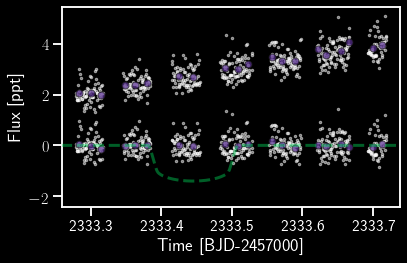

In [372]:
plt.figure(figsize=(8,6))
fig,cheops_c = plt.subplots()
binsize=1/48.
nch=2
tesstransix=abs(alldata['tess']['modtime']-info[2]['t0'])<0.3

t0=np.nanmedian(trace['transit_times_1'][:,-1])
bin_raw_cheops=tools.bin_lc_segment(np.column_stack((alldata['cheops_'+str(nch)]['time'],
                                                     3+alldata['cheops_'+str(nch)]['flux'],
                                                 alldata['cheops_'+str(nch)]['flux_err'])),binsize)
cheops_c.plot(alldata['cheops_'+str(nch)]['time'],3+alldata['cheops_'+str(nch)]['flux'],
         '.',alpha=0.5,label="cheops",color='w',markersize=5)
cheops_c.errorbar(bin_raw_cheops[:,0],bin_raw_cheops[:,1],yerr=bin_raw_cheops[:,2],
                  fmt='o',markeredgecolor='k',markersize=7,alpha=0.7,color='C1',ecolor='#777')
cheops_c.plot(alldata['cheops_'+str(nch)]['time']-t0,3+np.nanmedian(trace["flux_cor_cheops_"+str(nch)],axis=0),
                 '-',alpha=0.6,label="Detrending",color='C5',zorder=7)
#plt.plot(alldata[gd+'_lco']['time'],alldata[gd+'_lco']['flux']-soln['dfdairmass_'+gd+'_lco']*alldata[gd+'_lco']['airmass'],'.',label=gd)
#plt.plot(alldata[gd+'_lco']['time'],n*8+soln['dfdairmass_'+gd+'_lco']*alldata[gd+'_lco']['airmass']+soln['d2fdairmass2_'+gd+'_lco']*alldata[gd+'_lco']['airmass']**2,'.',label=gd)
#cheops12[nplot][0].legend()
bin_cheops=tools.bin_lc_segment(np.column_stack((alldata['cheops_'+str(nch)]['time'],
                                                 alldata['cheops_'+str(nch)]['flux']-np.nanmedian(trace["flux_cor_cheops_"+str(nch)],axis=0),
                                                 alldata['cheops_'+str(nch)]['flux_err'])),binsize)
cheops_c.plot(alldata['cheops_'+str(nch)]['time'],
           alldata['cheops_'+str(nch)]['flux']-np.nanmedian(trace["flux_cor_cheops_"+str(nch)],axis=0),
           '.',alpha=0.5,color='w',markersize=5)
cheops_c.errorbar(bin_cheops[:,0],bin_cheops[:,1],yerr=bin_cheops[:,2],
                  fmt='o',markeredgecolor='k',markersize=7,alpha=0.7,color='C1',ecolor='#777')
span=np.nanmedian(trace['transit_times_2'][:,1])-np.nanmedian(trace['transit_times_2'][:,0])
shift=span*(1+9/4)#,span*(1+14/6),span*(1+16/7)]
cheops_c.plot(np.arange(trace["planets_x_tess"].shape[1])*(2/1440)-(2.46+2.586)/2+np.nanmedian(trace['transit_times_2'][:,0])+shift,
              np.nanmedian(trace["planets_x_tess"],axis=0),'--',color='C6',alpha=0.4,zorder=100,linewidth=3)
#plt.plot(alldata[gd+'_lco']['time'],alldata[gd+'_lco']['flux']-soln['dfdairmass_'+gd+'_lco']*alldata[gd+'_lco']['airmass'],'.',label=gd)
#plt.plot(alldata[gd+'_lco']['time'],n*8+soln['dfdairmass_'+gd+'_lco']*alldata[gd+'_lco']['airmass']+soln['d2fdairmass2_'+gd+'_lco']*alldata[gd+'_lco']['airmass']**2,'.',label=gd)
#cheops12[nplot][1].set_ylim(-4,20.5)
cheops_c.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
#cheops_c.set_xlim(-0.22,+0.22)
cheops_c.set_xlim(alldata['cheops_'+str(nch)]['time'][0]-0.02,alldata['cheops_'+str(nch)]['time'][-1]+0.02)

cheops_c.set_xlabel("Time [BJD-2457000]")
cheops_c.set_ylabel("Flux [ppt]")
plt.tight_layout()
fig.savefig("talk_cheops_d_flat1.png",dpi=400,transparent=True)

<Figure size 576x432 with 0 Axes>

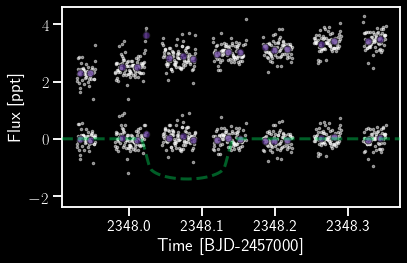

In [373]:
plt.figure(figsize=(8,6))
fig,cheops_c = plt.subplots()
binsize=1/48.
nch=0
tesstransix=abs(alldata['tess']['modtime']-info[2]['t0'])<0.3

t0=np.nanmedian(trace['transit_times_1'][:,-1])
bin_raw_cheops=tools.bin_lc_segment(np.column_stack((alldata['cheops_'+str(nch)]['time'],
                                                     3+alldata['cheops_'+str(nch)]['flux'],
                                                 alldata['cheops_'+str(nch)]['flux_err'])),binsize)
cheops_c.plot(alldata['cheops_'+str(nch)]['time'],3+alldata['cheops_'+str(nch)]['flux'],
         '.',alpha=0.5,label="cheops",color='w',markersize=5)
cheops_c.errorbar(bin_raw_cheops[:,0],bin_raw_cheops[:,1],yerr=bin_raw_cheops[:,2],
                  fmt='o',markeredgecolor='k',markersize=7,alpha=0.7,color='C1',ecolor='#777')
cheops_c.plot(alldata['cheops_'+str(nch)]['time']-t0,3+np.nanmedian(trace["flux_cor_cheops_"+str(nch)],axis=0),
                 '-',alpha=0.6,label="Detrending",color='C5',zorder=7)
#plt.plot(alldata[gd+'_lco']['time'],alldata[gd+'_lco']['flux']-soln['dfdairmass_'+gd+'_lco']*alldata[gd+'_lco']['airmass'],'.',label=gd)
#plt.plot(alldata[gd+'_lco']['time'],n*8+soln['dfdairmass_'+gd+'_lco']*alldata[gd+'_lco']['airmass']+soln['d2fdairmass2_'+gd+'_lco']*alldata[gd+'_lco']['airmass']**2,'.',label=gd)
#cheops12[nplot][0].legend()
bin_cheops=tools.bin_lc_segment(np.column_stack((alldata['cheops_'+str(nch)]['time'],
                                                 alldata['cheops_'+str(nch)]['flux']-np.nanmedian(trace["flux_cor_cheops_"+str(nch)],axis=0),
                                                 alldata['cheops_'+str(nch)]['flux_err'])),binsize)
cheops_c.plot(alldata['cheops_'+str(nch)]['time'],
           alldata['cheops_'+str(nch)]['flux']-np.nanmedian(trace["flux_cor_cheops_"+str(nch)],axis=0),
           '.',alpha=0.5,color='w',markersize=5)
cheops_c.errorbar(bin_cheops[:,0],bin_cheops[:,1],yerr=bin_cheops[:,2],
                  fmt='o',markeredgecolor='k',markersize=7,alpha=0.7,color='C1',ecolor='#777')
span=np.nanmedian(trace['transit_times_2'][:,1])-np.nanmedian(trace['transit_times_2'][:,0])
shift=span*(1+14/6)#span*(1+16/7)#span*(1+9/4)#,span*(1+14/6),span*(1+16/7)]
cheops_c.plot(np.arange(trace["planets_x_tess"].shape[1])*(2/1440)-(2.46+2.586)/2+np.nanmedian(trace['transit_times_2'][:,0])+shift,
              np.nanmedian(trace["planets_x_tess"],axis=0),'--',color='C6',alpha=0.4,zorder=100,linewidth=3)
#plt.plot(alldata[gd+'_lco']['time'],alldata[gd+'_lco']['flux']-soln['dfdairmass_'+gd+'_lco']*alldata[gd+'_lco']['airmass'],'.',label=gd)
#plt.plot(alldata[gd+'_lco']['time'],n*8+soln['dfdairmass_'+gd+'_lco']*alldata[gd+'_lco']['airmass']+soln['d2fdairmass2_'+gd+'_lco']*alldata[gd+'_lco']['airmass']**2,'.',label=gd)
#cheops12[nplot][1].set_ylim(-4,20.5)
cheops_c.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
#cheops_c.set_xlim(-0.22,+0.22)
cheops_c.set_xlim(alldata['cheops_'+str(nch)]['time'][0]-0.02,alldata['cheops_'+str(nch)]['time'][-1]+0.02)
cheops_c.set_ylabel("Flux [ppt]")
cheops_c.set_xlabel("Time [BJD-2457000]")
plt.tight_layout()
fig.savefig("talk_cheops_d_flat2.png",dpi=400,transparent=True)

<Figure size 576x432 with 0 Axes>

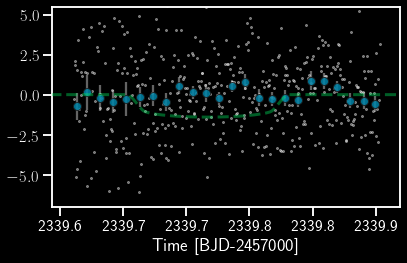

In [374]:
plt.figure(figsize=(8,6))
fig,lco3 = plt.subplots()
binsize=1/96.
lco3.plot(alldata['z_mcd']['time'],
             alldata['z_mcd']['flux']-np.nanmedian(trace["flux_cor_z_mcd"],axis=0),
           '.',alpha=0.4,color='w',markersize=4)
#lco3.plot(alldata['z_mcd']['time'],np.zeros(len(alldata['z_mcd']['time'])),
#         '-',alpha=0.5,color='C5',linewidth=3,zorder=100)
bin_lco=tools.bin_lc_segment(np.column_stack((alldata['z_mcd']['time'],
                                              alldata['z_mcd']['flux']-np.nanmedian(trace["flux_cor_z_mcd"],axis=0),
                                              alldata['z_mcd']['flux_err'])),binsize)
lco3.errorbar(bin_lco[:,0],bin_lco[:,1],yerr=bin_lco[:,2],
                            fmt='o',markeredgecolor='k',markersize=8,alpha=0.85,color='C3',ecolor='#777')

span=np.nanmedian(trace['transit_times_2'][:,1])-np.nanmedian(trace['transit_times_2'][:,0])
shift=span*(1+16/7)#span*(1+14/6)#span*(1+16/7)#span*(1+9/4)#,span*(1+14/6),]
lco3.plot(np.arange(trace["planets_x_tess"].shape[1])*(2/1440)-(2.46+2.586)/2+np.nanmedian(trace['transit_times_2'][:,0])+shift,
              np.nanmedian(trace["planets_x_tess"],axis=0),'--',color='C6',alpha=0.4,zorder=100,linewidth=3)
#plt.plot(alldata[gd+'_lco']['time'],alldata[gd+'_lco']['flux']-soln['dfdairmass_'+gd+'_lco']*alldata[gd+'_lco']['airmass'],'.',label=gd)
#plt.plot(alldata[gd+'_lco']['time'],n*8+soln['dfdairmass_'+gd+'_lco']*alldata[gd+'_lco']['airmass']+soln['d2fdairmass2_'+gd+'_lco']*alldata[gd+'_lco']['airmass']**2,'.',label=gd)
#cheops12[nplot][1].set_ylim(-4,20.5)
lco3.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
#cheops_c.set_xlim(-0.22,+0.22)
lco3.set_xlim(bin_lco[0,0]-0.02,bin_lco[-1,0]+0.02)
lco3.set_ylim(-7,5.5)

lco3.set_xlabel("Time [BJD-2457000]")
plt.tight_layout()
fig.savefig("talk_lco_d_flat3.png",dpi=400,transparent=True)

In [363]:
print(np.arange(trace["planets_x_tess"].shape[1])*(2/1440)-(2.46+2.586)/2+np.nanmedian(trace['transit_times_2'][:,0])+shift,)
print(alldata['cheops_'+str(nch)]['time'][0]-0.02,alldata['cheops_'+str(nch)]['time'][-1]+0.02)

[2337.19392407 2337.19531296 2337.19670185 ... 2343.23697962 2343.23836851
 2343.2397574 ]
2347.9085737997852 2348.3722293623537


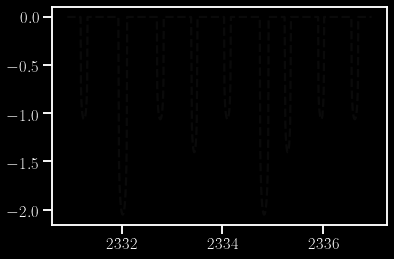

In [356]:
plt.plot(np.arange(trace["planets_x_tess"].shape[1])*(2/1440)-(2.46+2.586)/2+np.nanmedian(trace['transit_times_2'][:,0])+shift,
         np.nanmedian(trace["planets_x_tess"],axis=0),'--k',alpha=0.4,zorder=100)
#plt.xlim(alldata['cheops_'+str(nch)]['time'][0]-0.02,alldata['cheops_'+str(nch)]['time'][-1]+0.02)

array([2330.92165186, 2330.92304075, 2330.92442964, ..., 2336.96470742,
       2336.96609631, 2336.96748519])

In [342]:
np.arange(trace["planets_x_tess"].shape[1])*(2/1440)-(2.46+2.586)/2,

(array([-2.523     , -2.52161111, -2.52022222, ...,  3.52005556,
         3.52144444,  3.52283333]),)

In [323]:
alldata['tess']['time']

array([1738.64923721, 1738.65062606, 1738.6520149 , ..., 1954.87410692,
       1954.87688466, 1954.87827354])

In [ ]:
plt.figure(figsize=(8,6))
fig,cheops_c = plt.subplots()
binsize=1/48.
nch=0
t0=np.nanmedian(trace['transit_times_1'][:,-1])
bin_raw_cheops=tools.bin_lc_segment(np.column_stack((alldata['cheops_'+str(nch)]['time']-t0,
                                                     3+alldata['cheops_'+str(nch)]['flux'],
                                                 alldata['cheops_'+str(nch)]['flux_err'])),binsize)
cheops_c.plot(alldata['cheops_'+str(nch)]['time']-t0,3+alldata['cheops_'+str(nch)]['flux'],
         '.',alpha=0.5,label="cheops",color='w',markersize=5)
cheops_c.errorbar(bin_raw_cheops[:,0],bin_raw_cheops[:,1],yerr=bin_raw_cheops[:,2],
                  fmt='o',markeredgecolor='k',markersize=7,alpha=0.7,color='C1',ecolor='#777')
cheops_c.plot(alldata['cheops_'+str(nch)]['time']-t0,3+np.nanmedian(trace["flux_cor_cheops_"+str(nch)],axis=0),
                 '-',alpha=0.6,label="Detrending",color='C5',zorder=7)
#plt.plot(alldata[gd+'_lco']['time'],alldata[gd+'_lco']['flux']-soln['dfdairmass_'+gd+'_lco']*alldata[gd+'_lco']['airmass'],'.',label=gd)
#plt.plot(alldata[gd+'_lco']['time'],n*8+soln['dfdairmass_'+gd+'_lco']*alldata[gd+'_lco']['airmass']+soln['d2fdairmass2_'+gd+'_lco']*alldata[gd+'_lco']['airmass']**2,'.',label=gd)
#cheops12[nplot][0].legend()
bin_cheops=tools.bin_lc_segment(np.column_stack((alldata['cheops_'+str(nch)]['time']-t0,
                                                 alldata['cheops_'+str(nch)]['flux']-np.nanmedian(trace["flux_cor_cheops_"+str(nch)],axis=0),
                                                 alldata['cheops_'+str(nch)]['flux_err'])),binsize)
cheops_c.plot(alldata['cheops_'+str(nch)]['time']-t0,
           alldata['cheops_'+str(nch)]['flux']-np.nanmedian(trace["flux_cor_cheops_"+str(nch)],axis=0),
           '.',alpha=0.5,color='w',markersize=5)
cheops_c.errorbar(bin_cheops[:,0],bin_cheops[:,1],yerr=bin_cheops[:,2],
                  fmt='o',markeredgecolor='k',markersize=7,alpha=0.7,color='C1',ecolor='#777')
cheops_c.plot(alldata['cheops_'+str(nch)]['fine_time']-t0,
         np.nanmedian(trace["planetmodels_t_cheops_"+str(nch)],axis=0),
         '-',alpha=0.5,color='C5',linewidth=5)
#plt.plot(alldata[gd+'_lco']['time'],alldata[gd+'_lco']['flux']-soln['dfdairmass_'+gd+'_lco']*alldata[gd+'_lco']['airmass'],'.',label=gd)
#plt.plot(alldata[gd+'_lco']['time'],n*8+soln['dfdairmass_'+gd+'_lco']*alldata[gd+'_lco']['airmass']+soln['d2fdairmass2_'+gd+'_lco']*alldata[gd+'_lco']['airmass']**2,'.',label=gd)
#cheops12[nplot][1].set_ylim(-4,20.5)
cheops_c.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
cheops_c.set_xlim(-0.22,+0.22)
#cheops_c.set_xlim(alldata['cheops_'+str(nch)]['time'][0]-0.02,alldata['cheops_'+str(nch)]['time'][-1]+0.02)

cheops_c.set_xlabel("Time from transit [d]")
plt.tight_layout()
fig.savefig("talk_cheops_d_flat2.png",dpi=400,transparent=True)

<Figure size 576x432 with 0 Axes>

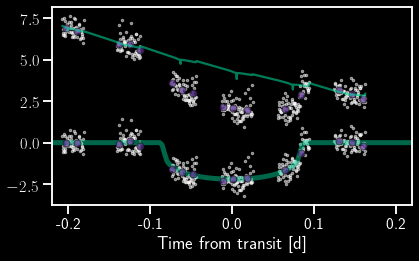

In [306]:
plt.figure(figsize=(8,6))
fig,cheops_c = plt.subplots()
binsize=1/48.
nch=3
t0=np.nanmedian(trace['transit_times_1'][:,-1])
bin_raw_cheops=tools.bin_lc_segment(np.column_stack((alldata['cheops_'+str(nch)]['time']-t0,
                                                     3+alldata['cheops_'+str(nch)]['flux'],
                                                 alldata['cheops_'+str(nch)]['flux_err'])),binsize)
cheops_c.plot(alldata['cheops_'+str(nch)]['time']-t0,3+alldata['cheops_'+str(nch)]['flux'],
         '.',alpha=0.5,label="cheops",color='w',markersize=5)
cheops_c.errorbar(bin_raw_cheops[:,0],bin_raw_cheops[:,1],yerr=bin_raw_cheops[:,2],
                  fmt='o',markeredgecolor='k',markersize=7,alpha=0.7,color='C1',ecolor='#777')
cheops_c.plot(alldata['cheops_'+str(nch)]['time']-t0,3+np.nanmedian(trace["flux_cor_cheops_"+str(nch)],axis=0),
                 '-',alpha=0.6,label="Detrending",color='C5',zorder=7)
#plt.plot(alldata[gd+'_lco']['time'],alldata[gd+'_lco']['flux']-soln['dfdairmass_'+gd+'_lco']*alldata[gd+'_lco']['airmass'],'.',label=gd)
#plt.plot(alldata[gd+'_lco']['time'],n*8+soln['dfdairmass_'+gd+'_lco']*alldata[gd+'_lco']['airmass']+soln['d2fdairmass2_'+gd+'_lco']*alldata[gd+'_lco']['airmass']**2,'.',label=gd)
#cheops12[nplot][0].legend()
bin_cheops=tools.bin_lc_segment(np.column_stack((alldata['cheops_'+str(nch)]['time']-t0,
                                                 alldata['cheops_'+str(nch)]['flux']-np.nanmedian(trace["flux_cor_cheops_"+str(nch)],axis=0),
                                                 alldata['cheops_'+str(nch)]['flux_err'])),binsize)
cheops_c.plot(alldata['cheops_'+str(nch)]['time']-t0,
           alldata['cheops_'+str(nch)]['flux']-np.nanmedian(trace["flux_cor_cheops_"+str(nch)],axis=0),
           '.',alpha=0.5,color='w',markersize=5)
cheops_c.errorbar(bin_cheops[:,0],bin_cheops[:,1],yerr=bin_cheops[:,2],
                  fmt='o',markeredgecolor='k',markersize=7,alpha=0.7,color='C1',ecolor='#777')
cheops_c.plot(alldata['cheops_'+str(nch)]['fine_time']-t0,
         np.nanmedian(trace["planetmodels_t_cheops_"+str(nch)],axis=0),
         '-',alpha=0.5,color='C5',linewidth=5)
#plt.plot(alldata[gd+'_lco']['time'],alldata[gd+'_lco']['flux']-soln['dfdairmass_'+gd+'_lco']*alldata[gd+'_lco']['airmass'],'.',label=gd)
#plt.plot(alldata[gd+'_lco']['time'],n*8+soln['dfdairmass_'+gd+'_lco']*alldata[gd+'_lco']['airmass']+soln['d2fdairmass2_'+gd+'_lco']*alldata[gd+'_lco']['airmass']**2,'.',label=gd)
#cheops12[nplot][1].set_ylim(-4,20.5)
cheops_c.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
cheops_c.set_xlim(-0.22,+0.22)
#cheops_c.set_xlim(alldata['cheops_'+str(nch)]['time'][0]-0.02,alldata['cheops_'+str(nch)]['time'][-1]+0.02)

cheops_c.set_xlabel("Time from transit [d]")
plt.tight_layout()
fig.savefig("talk_cheops_c.png",dpi=400,transparent=True)

<Figure size 576x432 with 0 Axes>

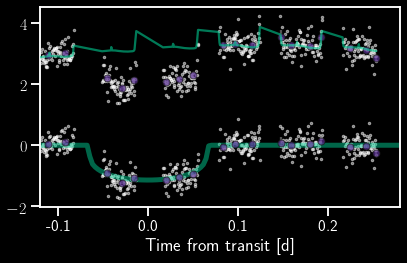

In [309]:
plt.figure(figsize=(8,6))
fig,cheops_c = plt.subplots()
binsize=1/48.
nch=1
t0=np.nanmedian(trace['transit_times_0'][:,-1])
bin_raw_cheops=tools.bin_lc_segment(np.column_stack((alldata['cheops_'+str(nch)]['time']-t0,
                                                     3+alldata['cheops_'+str(nch)]['flux'],
                                                 alldata['cheops_'+str(nch)]['flux_err'])),binsize)
cheops_c.plot(alldata['cheops_'+str(nch)]['time']-t0,3+alldata['cheops_'+str(nch)]['flux'],
         '.',alpha=0.5,label="cheops",color='w',markersize=5)
cheops_c.errorbar(bin_raw_cheops[:,0],bin_raw_cheops[:,1],yerr=bin_raw_cheops[:,2],
                  fmt='o',markeredgecolor='k',markersize=7,alpha=0.7,color='C1',ecolor='#777')
cheops_c.plot(alldata['cheops_'+str(nch)]['time']-t0,3+np.nanmedian(trace["flux_cor_cheops_"+str(nch)],axis=0),
                 '-',alpha=0.6,label="Detrending",color='C5',zorder=7)
#plt.plot(alldata[gd+'_lco']['time'],alldata[gd+'_lco']['flux']-soln['dfdairmass_'+gd+'_lco']*alldata[gd+'_lco']['airmass'],'.',label=gd)
#plt.plot(alldata[gd+'_lco']['time'],n*8+soln['dfdairmass_'+gd+'_lco']*alldata[gd+'_lco']['airmass']+soln['d2fdairmass2_'+gd+'_lco']*alldata[gd+'_lco']['airmass']**2,'.',label=gd)
#cheops12[nplot][0].legend()
bin_cheops=tools.bin_lc_segment(np.column_stack((alldata['cheops_'+str(nch)]['time']-t0,
                                                 alldata['cheops_'+str(nch)]['flux']-np.nanmedian(trace["flux_cor_cheops_"+str(nch)],axis=0),
                                                 alldata['cheops_'+str(nch)]['flux_err'])),binsize)
cheops_c.plot(alldata['cheops_'+str(nch)]['time']-t0,
           alldata['cheops_'+str(nch)]['flux']-np.nanmedian(trace["flux_cor_cheops_"+str(nch)],axis=0),
           '.',alpha=0.5,color='w',markersize=5)
cheops_c.errorbar(bin_cheops[:,0],bin_cheops[:,1],yerr=bin_cheops[:,2],
                  fmt='o',markeredgecolor='k',markersize=7,alpha=0.7,color='C1',ecolor='#777')
cheops_c.plot(alldata['cheops_'+str(nch)]['fine_time']-t0,
         np.nanmedian(trace["planetmodels_t_cheops_"+str(nch)],axis=0),
         '-',alpha=0.5,color='C5',linewidth=5)
#plt.plot(alldata[gd+'_lco']['time'],alldata[gd+'_lco']['flux']-soln['dfdairmass_'+gd+'_lco']*alldata[gd+'_lco']['airmass'],'.',label=gd)
#plt.plot(alldata[gd+'_lco']['time'],n*8+soln['dfdairmass_'+gd+'_lco']*alldata[gd+'_lco']['airmass']+soln['d2fdairmass2_'+gd+'_lco']*alldata[gd+'_lco']['airmass']**2,'.',label=gd)
#cheops12[nplot][1].set_ylim(-4,20.5)
cheops_c.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
cheops_c.set_xlim(-0.12,+0.28)
#cheops_c.set_xlim(alldata['cheops_'+str(nch)]['time'][0]-0.02,alldata['cheops_'+str(nch)]['time'][-1]+0.02)

cheops_c.set_xlabel("Time from transit [d]")
plt.tight_layout()
fig.savefig("talk_cheops_b.png",dpi=400,transparent=True)

IndexError: boolean index did not match indexed array along dimension 1; dimension is 4354 but corresponding boolean dimension is 4364

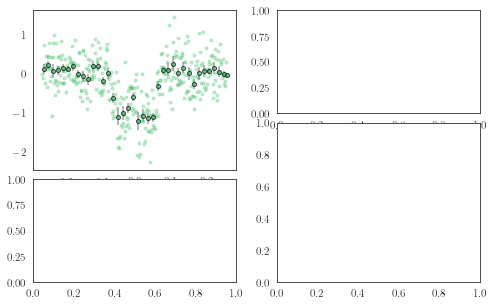

In [13]:
binsize=20/1440
fig=plt.figure(figsize=(8,5))

gs = gridspec.GridSpec(nrows=5,ncols=2, figure=fig)
tess_b =   fig.add_subplot(gs[:3, 0])
cheops_b = fig.add_subplot(gs[3:, 0])
tess_c =   fig.add_subplot(gs[:2, 1])
cheops_c = fig.add_subplot(gs[2:, 1])

for i in range(5):
    t0=np.nanmedian(trace['transit_times_0'][:,i])
    tess_b.plot(alldata['tess']['modtime'][abs(alldata['tess']['modtime']-t0)<0.255]-t0,
                i*3+alldata['tess']['modflux'][abs(alldata['tess']['modtime']-t0)<0.255],
                '.',color='C'+str(2+2),alpha=0.3)
    bin_tess=tools.bin_lc_segment(np.column_stack((alldata['tess']['modtime'][abs(alldata['tess']['modtime']-t0)<0.255]-t0,
                                          i*3+alldata['tess']['modflux'][abs(alldata['tess']['modtime']-t0)<0.255],
                                          i*3+alldata['tess']['modflux_err'][abs(alldata['tess']['modtime']-t0)<0.255])),binsize)
    tess_b.errorbar(bin_tess[:,0],bin_tess[:,1],yerr=bin_tess[:,2],
                    fmt='o',markeredgecolor='k',markersize=4,alpha=0.7,color='C'+str(2+2),ecolor='#777')

    tess_b.plot(alldata['tess']['modtime'][abs(alldata['tess']['modtime']-t0)<0.255]-t0,
                i*3+np.nanmedian(trace['planets_x_tess'][:,abs(alldata['tess']['modtime']-t0)<0.255],axis=0),
                '-',color='C0')
tess_b.set_xticklabels([])
    
nch=1
t0=np.nanmedian(trace['transit_times_0'][:,-1])
bin_raw_cheops=tools.bin_lc_segment(np.column_stack((alldata['cheops_'+str(nch)]['time']-t0,
                                                     2.4+alldata['cheops_'+str(nch)]['flux'],
                                                     alldata['cheops_'+str(nch)]['flux_err'])),binsize)
cheops_b.plot(alldata['cheops_'+str(nch)]['time']-t0,2.4+alldata['cheops_'+str(nch)]['flux'],
         '.',alpha=0.25,label="cheops",color='C'+str(2))
cheops_b.errorbar(bin_raw_cheops[:,0],bin_raw_cheops[:,1],yerr=bin_raw_cheops[:,2],
                            fmt='o',markeredgecolor='k',markersize=4,alpha=0.7,color='C'+str(2),ecolor='#777')
cheops_b.plot(alldata['cheops_'+str(nch)]['time']-t0,2.4+np.nanmedian(trace["flux_cor_cheops_"+str(nch)],axis=0),
                 '-',alpha=0.6,label="Detrending",color='C0')

#plt.plot(alldata[gd+'_lco']['time'],alldata[gd+'_lco']['flux']-soln['dfdairmass_'+gd+'_lco']*alldata[gd+'_lco']['airmass'],'.',label=gd)
#plt.plot(alldata[gd+'_lco']['time'],n*8+soln['dfdairmass_'+gd+'_lco']*alldata[gd+'_lco']['airmass']+soln['d2fdairmass2_'+gd+'_lco']*alldata[gd+'_lco']['airmass']**2,'.',label=gd)
#cheops12[nplot][0].legend()
bin_cheops=tools.bin_lc_segment(np.column_stack((alldata['cheops_'+str(nch)]['time']-t0,
                                                 alldata['cheops_'+str(nch)]['flux']-np.nanmedian(trace["flux_cor_cheops_"+str(nch)],axis=0),
                                                 alldata['cheops_'+str(nch)]['flux_err'])),binsize)
cheops_b.plot(alldata['cheops_'+str(nch)]['time']-t0,
           alldata['cheops_'+str(nch)]['flux']-np.nanmedian(trace["flux_cor_cheops_"+str(nch)],axis=0),
           '.',alpha=0.25,color='C'+str(0+2))
cheops_b.errorbar(bin_cheops[:,0],bin_cheops[:,1],yerr=bin_cheops[:,2],
                  fmt='o',markeredgecolor='k',markersize=4,alpha=0.7,color='C'+str(2),ecolor='#777')
cheops_b.plot(alldata['cheops_'+str(nch)]['fine_time']-t0,
         np.nanmedian(trace["planetmodels_t_cheops_"+str(nch)],axis=0),
         '-',alpha=0.5,color='C0',linewidth=3)
    #plt.plot(alldata[gd+'_lco']['time'],alldata[gd+'_lco']['flux']-soln['dfdairmass_'+gd+'_lco']*alldata[gd+'_lco']['airmass'],'.',label=gd)
    #plt.plot(alldata[gd+'_lco']['time'],n*8+soln['dfdairmass_'+gd+'_lco']*alldata[gd+'_lco']['airmass']+soln['d2fdairmass2_'+gd+'_lco']*alldata[gd+'_lco']['airmass']**2,'.',label=gd)
#cheops12[nplot][1].set_ylim(-4,20.5)
cheops_b.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))

cheops_b.set_xlim(-0.255,+0.255)
#alldata['cheops_'+str(nch)]['time'][0]-0.02,alldata['cheops_'+str(nch)]['time'][-1]+0.02)


for i in range(2):
    t0=np.nanmedian(trace['transit_times_1'][:,i])
    tess_c.plot(alldata['tess']['modtime'][abs(alldata['tess']['modtime']-t0)<0.255]-t0,
                i*3+alldata['tess']['modflux'][abs(alldata['tess']['modtime']-t0)<0.255],
                '.',color='C'+str(2+2),alpha=0.3)
    bin_tess=tools.bin_lc_segment(np.column_stack((alldata['tess']['modtime'][abs(alldata['tess']['modtime']-t0)<0.255]-t0,
                                          i*3+alldata['tess']['modflux'][abs(alldata['tess']['modtime']-t0)<0.255],
                                          i*3+alldata['tess']['modflux_err'][abs(alldata['tess']['modtime']-t0)<0.255])),binsize)
    tess_c.errorbar(bin_tess[:,0],bin_tess[:,1],yerr=bin_tess[:,2],
                    fmt='o',markeredgecolor='k',markersize=4,alpha=0.7,color='C'+str(2+2),ecolor='#777')
    tess_c.plot(alldata['tess']['modtime'][abs(alldata['tess']['modtime']-t0)<0.255]-t0,
                i*3+np.nanmedian(trace['planets_x_tess'][:,abs(alldata['tess']['modtime']-t0)<0.255,1],axis=0),
                '-',color='C0')
tess_c.set_xticklabels([])
tess_c.set_xlim(-0.22,+0.22)

nch=3
t0=np.nanmedian(trace['transit_times_1'][:,-1])
bin_raw_cheops=tools.bin_lc_segment(np.column_stack((alldata['cheops_'+str(nch)]['time']-t0,
                                                     3+alldata['cheops_'+str(nch)]['flux'],
                                                 alldata['cheops_'+str(nch)]['flux_err'])),binsize)
cheops_c.plot(alldata['cheops_'+str(nch)]['time']-t0,3+alldata['cheops_'+str(nch)]['flux'],
         '.',alpha=0.25,label="cheops",color='C'+str(2))
cheops_c.errorbar(bin_raw_cheops[:,0],bin_raw_cheops[:,1],yerr=bin_raw_cheops[:,2],
                  fmt='o',markeredgecolor='k',markersize=4,alpha=0.7,color='C'+str(2),ecolor='#777')
cheops_c.plot(alldata['cheops_'+str(nch)]['time']-t0,3+np.nanmedian(trace["flux_cor_cheops_"+str(nch)],axis=0),
                 '-',alpha=0.6,label="Detrending",color='C0',zorder=7)
#plt.plot(alldata[gd+'_lco']['time'],alldata[gd+'_lco']['flux']-soln['dfdairmass_'+gd+'_lco']*alldata[gd+'_lco']['airmass'],'.',label=gd)
#plt.plot(alldata[gd+'_lco']['time'],n*8+soln['dfdairmass_'+gd+'_lco']*alldata[gd+'_lco']['airmass']+soln['d2fdairmass2_'+gd+'_lco']*alldata[gd+'_lco']['airmass']**2,'.',label=gd)
#cheops12[nplot][0].legend()
bin_cheops=tools.bin_lc_segment(np.column_stack((alldata['cheops_'+str(nch)]['time']-t0,
                                                 alldata['cheops_'+str(nch)]['flux']-np.nanmedian(trace["flux_cor_cheops_"+str(nch)],axis=0),
                                                 alldata['cheops_'+str(nch)]['flux_err'])),binsize)
cheops_c.plot(alldata['cheops_'+str(nch)]['time']-t0,
           alldata['cheops_'+str(nch)]['flux']-np.nanmedian(trace["flux_cor_cheops_"+str(nch)],axis=0),
           '.',alpha=0.25,color='C'+str(0+2))
cheops_c.errorbar(bin_cheops[:,0],bin_cheops[:,1],yerr=bin_cheops[:,2],
                  fmt='o',markeredgecolor='k',markersize=4,alpha=0.7,color='C'+str(2),ecolor='#777')
cheops_c.plot(alldata['cheops_'+str(nch)]['fine_time']-t0,
         np.nanmedian(trace["planetmodels_t_cheops_"+str(nch)],axis=0),
         '-',alpha=0.5,color='C0',linewidth=3)
#plt.plot(alldata[gd+'_lco']['time'],alldata[gd+'_lco']['flux']-soln['dfdairmass_'+gd+'_lco']*alldata[gd+'_lco']['airmass'],'.',label=gd)
#plt.plot(alldata[gd+'_lco']['time'],n*8+soln['dfdairmass_'+gd+'_lco']*alldata[gd+'_lco']['airmass']+soln['d2fdairmass2_'+gd+'_lco']*alldata[gd+'_lco']['airmass']**2,'.',label=gd)
#cheops12[nplot][1].set_ylim(-4,20.5)
cheops_c.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
cheops_c.set_xlim(-0.22,+0.22)
#cheops_c.set_xlim(alldata['cheops_'+str(nch)]['time'][0]-0.02,alldata['cheops_'+str(nch)]['time'][-1]+0.02)

cheops_b.set_xlabel("Time from transit [d]")
cheops_c.set_xlabel("Time from transit [d]")

fig.subplots_adjust(wspace=0.1)

fig.text(0.06, 0.5, 'Normalised flux [ppt]', va='center', rotation='vertical')

fig.savefig("TOI-2076CheopsPaper/all_bc_transits.pdf")


In [67]:
print(trace['planets_x_tess'].shape, len(abs(alldata['tess']['modtime']-t0)<0.255))

(28000, 4364) 4280


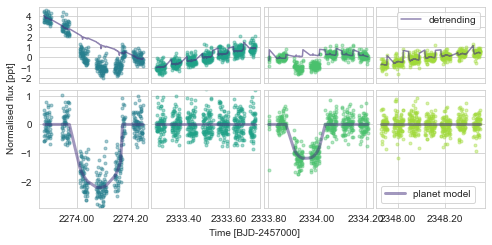

In [154]:
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter

fig=plt.figure(figsize=(8,3.7))
gs = gridspec.GridSpec(ncols=4, nrows=5, figure=fig,wspace=0.03)
raws = {n:fig.add_subplot(gs[:2, n]) for n in range(4)}
detrendeds = {n:fig.add_subplot(gs[2:, n]) for n in range(4)}

for n in range(4):
    raws[n].plot(alldata['cheops_'+str(3-n)]['time'],np.nanmedian(trace["flux_cor_cheops_"+str(3-n)],axis=0),
                 '-',alpha=0.6,label="detrending",color='C0',zorder=7)
    #plt.plot(alldata[gd+'_lco']['time'],n*8+soln['dfdairmass_'+gd+'_lco']*alldata[gd+'_lco']['airmass'])
    raws[n].plot(alldata['cheops_'+str(3-n)]['time'],alldata['cheops_'+str(3-n)]['flux'],
             '.',alpha=0.4,color='C'+str(n+2))
    #plt.plot(alldata[gd+'_lco']['time'],alldata[gd+'_lco']['flux']-soln['dfdairmass_'+gd+'_lco']*alldata[gd+'_lco']['airmass'],'.',label=gd)
    #plt.plot(alldata[gd+'_lco']['time'],n*8+soln['dfdairmass_'+gd+'_lco']*alldata[gd+'_lco']['airmass']+soln['d2fdairmass2_'+gd+'_lco']*alldata[gd+'_lco']['airmass']**2,'.',label=gd)
    if n>0:
        raws[n].set_yticklabels([])
        
    #raws[n].legend()
    raws[n].set_xticklabels([])
    raws[n].set_ylim(-2.5,4.95)
    raws[n].set_yticks(np.arange(-2,4.1,1))
    if n==3:
        raws[n].legend()

for n,gd in enumerate('griz'):
    #plt.plot(alldata[gd+'_lco']['time'],n*8+soln['dfdairmass_'+gd+'_lco']*alldata[gd+'_lco']['airmass'])
    detrendeds[n].plot(alldata['cheops_'+str(3-n)]['time'],
               alldata['cheops_'+str(3-n)]['flux']-np.nanmedian(trace["flux_cor_cheops_"+str(3-n)],axis=0),
               '.',alpha=0.4,color='C'+str(n+2))
    detrendeds[n].plot(alldata['cheops_'+str(3-n)]['time'],
             np.nanmedian(trace["planets_x_cheops_"+str(3-n)],axis=0),
             '-',alpha=0.5,color='C0',linewidth=3,label='planet model')

    #plt.plot(alldata[gd+'_lco']['time'],alldata[gd+'_lco']['flux']-soln['dfdairmass_'+gd+'_lco']*alldata[gd+'_lco']['airmass'],'.',label=gd)
    #plt.plot(alldata[gd+'_lco']['time'],n*8+soln['dfdairmass_'+gd+'_lco']*alldata[gd+'_lco']['airmass']+soln['d2fdairmass2_'+gd+'_lco']*alldata[gd+'_lco']['airmass']**2,'.',label=gd)
    #detrendeds.legend()
    detrendeds[n].set_yticks(np.arange(-3,1.1,1))
    detrendeds[n].set_ylim(-2.9,1.2)
    detrendeds[n].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    #detrendeds[n].set_xlabel("BJD-2457000")
    if n>0:
        detrendeds[n].set_yticklabels([])
    if n==3:
        detrendeds[n].legend()

fig.text(0.5, 0.02, 'Time [BJD-2457000]', ha='center')
fig.text(0.07, 0.5, 'Normalised flux [ppt]', va='center', rotation='vertical')

fig.savefig("TOI-2076CheopsPaper/cheops_data.pdf")


In [ ]:
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter

fig=plt.figure(figsize=(3.8,7.5))
gs = gridspec.GridSpec(ncols=1, nrows=6, figure=fig)
raw = fig.add_subplot(gs[:2, :])
detrended = fig.add_subplot(gs[2:, :])

raw.plot(alldata['r_sex']['time'],n*12+np.nanmedian(trace["flux_cor_"+gd+'_lco'],axis=0),
         '-',alpha=0.6,label="Detrending",color='C0',zorder=7)
raw.plot(alldata[gd+'_lco']['time'],n*12+np.nanmedian(trace["flux_cor_"+gd+'_lco'],axis=0),
         '-',alpha=0.6,color='C0',zorder=7)
    #plt.plot(alldata[gd+'_lco']['time'],n*8+soln['dfdairmass_'+gd+'_lco']*alldata[gd+'_lco']['airmass'])
    raw.plot(alldata[gd+'_lco']['time'],n*12+alldata[gd+'_lco']['flux'],
             '.',alpha=0.4,label="Muscat3/"+gd,color='C'+str(n+2))
    #plt.plot(alldata[gd+'_lco']['time'],alldata[gd+'_lco']['flux']-soln['dfdairmass_'+gd+'_lco']*alldata[gd+'_lco']['airmass'],'.',label=gd)
    #plt.plot(alldata[gd+'_lco']['time'],n*8+soln['dfdairmass_'+gd+'_lco']*alldata[gd+'_lco']['airmass']+soln['d2fdairmass2_'+gd+'_lco']*alldata[gd+'_lco']['airmass']**2,'.',label=gd)
raw.legend()
raw.set_xticklabels([])
raw.set_ylabel("Normalised flux [ppt]")

detrended2=detrended.twinx()

for n,gd in enumerate('griz'):
    #plt.plot(alldata[gd+'_lco']['time'],n*8+soln['dfdairmass_'+gd+'_lco']*alldata[gd+'_lco']['airmass'])
    if n%2==0:
        detrended2.plot(alldata[gd+'_lco']['time'],
                   n*6+alldata[gd+'_lco']['flux']-np.nanmedian(trace["flux_cor_"+gd+'_lco'],axis=0),
                   '.',alpha=0.4,label="LCO/Muscat3 "+gd,color='C'+str(n+2))
        detrended2.plot(alldata[gd+'_lco']['time'],
                 n*6+np.nanmedian(trace["planets_x_"+gd+'_lco'],axis=0),
                 '-',alpha=0.5,color='C0',linewidth=3)

    else:
        detrended.plot(alldata[gd+'_lco']['time'],
                   n*6+alldata[gd+'_lco']['flux']-np.nanmedian(trace["flux_cor_"+gd+'_lco'],axis=0),
                   '.',alpha=0.4,label="LCO/MuSCAT3 "+gd,color='C'+str(n+2))
        detrended.plot(alldata[gd+'_lco']['time'],
                 n*6+np.nanmedian(trace["planets_x_"+gd+'_lco'],axis=0),
                 '-',alpha=0.5,color='C0',linewidth=3)

    #plt.plot(alldata[gd+'_lco']['time'],alldata[gd+'_lco']['flux']-soln['dfdairmass_'+gd+'_lco']*alldata[gd+'_lco']['airmass'],'.',label=gd)
    #plt.plot(alldata[gd+'_lco']['time'],n*8+soln['dfdairmass_'+gd+'_lco']*alldata[gd+'_lco']['airmass']+soln['d2fdairmass2_'+gd+'_lco']*alldata[gd+'_lco']['airmass']**2,'.',label=gd)
detrended.legend()
detrended.set_yticks(np.arange(-4,21,2))
detrended2.set_yticks(np.arange(-4,21,2))
detrended.set_ylim(-4,20.5)
detrended2.set_ylim(-4,20.5)

detrended.set_yticklabels(list(np.arange(-4,5,2).astype(str))+['']+list(np.arange(-4,5,2).astype(str))+['',''])
detrended2.set_yticklabels(['','','']+list(np.arange(-4,5,2).astype(str))+['']+list(np.arange(-4,3,2).astype(str)))

detrended.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

detrended.set_xlabel("BJD-2457000")
detrended.set_ylabel("Normalised flux [ppt]")
fig.savefig("TOI-2076CheopsPaper/LCO_mjd_data.pdf")


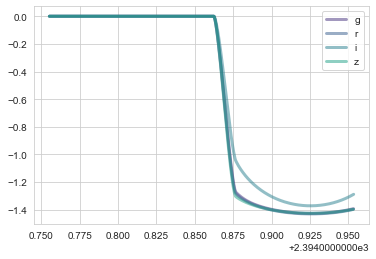

In [101]:
for n,gd in enumerate('griz'):
    plt.plot(alldata[gd+'_lco']['time'],
             np.nanmedian(np.nansum(trace["planets_x_"+gd+'_lco'],axis=2),axis=0),
                 '-',alpha=0.5,linewidth=3,label=gd)
plt.legend()

In [92]:
detrended.set_ylabel?

In [4]:
df=pd.read_csv("/Users/hosborn/Downloads/young_planets.csv",comment='#')


def logmass_func(R):
    return 5.75402469 - (R<=12.2)*(R>=1.58)*(4.67363091 -0.38348534*R) - (R<1.58)*(5.81943841-3.81604756*np.log(R))
def logmass_sd_func(R):
    return (R<=8)*(0.07904372*R+0.24318296) + (R>8)*(0-0.02313261*R+1.06765343)

df['T_eq_p']=df['st_teff']*(df['pl_orbsmax']*215/df['st_rad'])**(-0.5)*0.707107
df['T_eq_perr1']=(df['st_teff']+df['st_tefferr1'])*(df['pl_orbsmax']*215/(df['st_rad']+df['st_raderr2']))**(-0.5)*0.707107-df['T_eq_p']
df['T_eq_perr2']=(df['st_teff']+df['st_tefferr2'])*(df['pl_orbsmax']*215/(df['st_rad']+df['st_raderr1']))**(-0.5)*0.707107-df['T_eq_p']
df.loc[pd.isnull(df['pl_masse']),'pl_masse']=np.exp(logmass_func(df.loc[pd.isnull(df['pl_masse']),'pl_rade']))
df.loc[pd.isnull(df['pl_masseerr1']),'pl_masseerr1']=np.exp(df.loc[pd.isnull(df['pl_masseerr1']),'pl_masse']+logmass_sd_func(df.loc[pd.isnull(df['pl_masseerr1']),'pl_rade']))
df.loc[pd.isnull(df['pl_masseerr2']),'pl_masseerr2']=-1*np.exp(df.loc[pd.isnull(df['pl_masseerr2']),'pl_masse']-logmass_sd_func(df.loc[pd.isnull(df['pl_masseerr2']),'pl_rade']))
df['TSM']=df['pl_rade']**3*df['T_eq_p']/(df['pl_masse']*df['st_rad']**2)*np.power(10,-0.2*df['sy_kmag'])
df['TSMerr1']=(df['pl_rade']+df['pl_radeerr1'])**3*(df['T_eq_p']+df['T_eq_perr1'])/((df['pl_masse']+df['pl_masseerr2'])*(df['st_rad']+df['st_raderr2'])**2)*np.power(10,-0.2*df['sy_kmag'])-df['TSM']
df['TSMerr2']=(df['pl_rade']+df['pl_radeerr2'])**3*(df['T_eq_p']+df['T_eq_perr2'])/((df['pl_masse']+df['pl_masseerr1'])*(df['st_rad']+df['st_raderr1'])**2)*np.power(10,-0.2*df['sy_kmag'])-df['TSM']

df.loc[df.hostname=='TOI-2076','st_age']=0.34
df.loc[df.hostname=='TOI-2076','st_ageerr1']=0.08
df.loc[df.hostname=='TOI-2076','st_ageerr2']=0.08

TOI-2076


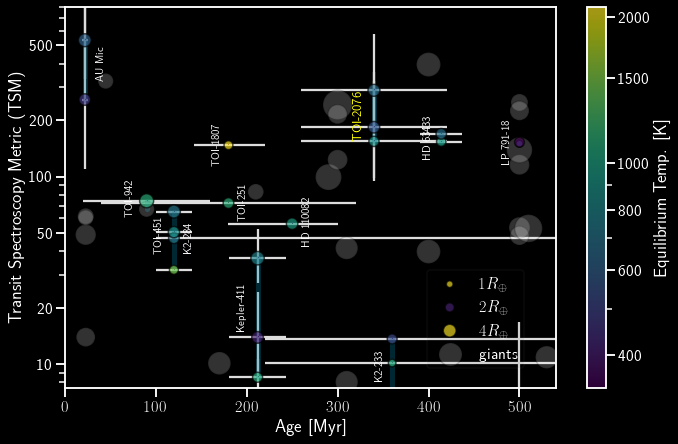

In [34]:
sns.set(style="ticks", context="talk")
plt.style.use("dark_background")
sns.set_palette(viridis_light)

text_pos={'AU Mic':['b'],'HAT-P-70':['r'],'HATS-67':[],'HD 110082':['b','r'],'HD 63433':[],'K2-136':[],
          'K2-233':[],'K2-264':[],'Kepler-289':[],'Kepler-411':[],
          'KELT-17':[],'KELT-20':['b'],'KELT-9':['b'],'Kepler-45':['b'],'DS Tuc A':['b'],'V1298 Tau':['b','l'],
          'Kepler-51':[],'LP 791-18':[],'TOI-1431':['r'],'TOI-1807':[],'K2-100':['l'],'K2-284':['b'],
          'TOI-2076':[],'TOI-451':['l'],'WASP-132':[],'WASP-135':['b'],'TOI-251':['b'],'TOI-942':['r'],
          'WASP-139':[],'WASP-140':[],'WASP-52':[],'WASP-93':[],'WTS-2':['r'],'HD 73583':['r']}

import matplotlib
import matplotlib.ticker as mticker
maxage=0.54
tsm_min=5

plt.figure(figsize=(11,7))
scatcuts=(df['st_age']<maxage)&(df['pl_rade']<5)

missed_multis=df['pl_rade']>5

cuts=(df['TSM']>tsm_min)&(df['st_age']<maxage)&(df['pl_rade']<5)

for star in np.unique(df.loc[cuts,'hostname'].values):
    rows=df.loc[df['hostname']==star]
    plt.plot(1000*rows['st_age'],rows['TSM'],'-',linewidth=5,alpha=0.3,color='C3',zorder=0)

plt.errorbar(1000*df.loc[scatcuts,'st_age'],df.loc[scatcuts,'TSM'],
             xerr=[abs(1000*df.loc[scatcuts,'st_ageerr2'].values),1000*df.loc[scatcuts,'st_ageerr1'].values],
             yerr=[abs(df.loc[scatcuts,'TSMerr2'].values),df.loc[scatcuts,'TSMerr1'].values],
             fmt=',',ecolor='#ddd',zorder=-10)

plt.scatter(np.random.random(5)-100,np.random.random(5),
            s=4+40*np.tile(1,5),c=500+1000*np.random.random(5),cmap='viridis',
            norm=matplotlib.colors.LogNorm(),alpha=0.66,edgecolors= "black",label='$1R_\\oplus$')#1Re')#$1R_\\oplus$')
plt.scatter(np.random.random(5)-100,np.random.random(5),
            s=4+40*np.tile(2,5),c=500+1000*np.random.random(5),cmap='viridis',
            norm=matplotlib.colors.LogNorm(),alpha=0.66,edgecolors= "black",label='$2R_\\oplus$')#2.5Re')#$2.5R_\\oplus$')
plt.scatter(np.random.random(5)-100,np.random.random(5),
            s=4+40*np.tile(4,5),c=500+1000*np.random.random(5),cmap='viridis',
            norm=matplotlib.colors.LogNorm(),alpha=0.66,edgecolors= "black",label='$4R_\\oplus$')#5Re')#$

plt.scatter(1000*df.loc[missed_multis,'st_age'],df.loc[missed_multis,'TSM'],
            s=4+40*df.loc[missed_multis,'pl_rade'],c='w',
            norm=matplotlib.colors.LogNorm(),alpha=0.2,edgecolors= "black",label='giants')

plt.scatter(1000*df.loc[scatcuts,'st_age'],df.loc[scatcuts,'TSM'],
            s=4+40*df.loc[scatcuts,'pl_rade'],c=df.loc[scatcuts,'T_eq_p'],cmap='viridis',
            norm=matplotlib.colors.LogNorm(),alpha=0.66,edgecolors= "black")
cbar=plt.colorbar(format='%.0f',label='Equilibrium Temp. [K]')
cbar.set_ticks([400,600,800,1000,1500,2000])


#cbar.set_major_formatter(mticker.ScalarFormatter())
plt.xlabel("Age [Myr]")
for star in np.unique(df.loc[cuts,'hostname'].values):
    rows=df.loc[cuts*(df['hostname']==star)]
    if 'b' in text_pos[star]:
        xoff=np.clip(1.2*np.sqrt(50+40*np.max(rows['pl_rade'])),0,80)
    else:
        xoff=-1*np.clip(1.2*np.sqrt(50+40*np.max(rows['pl_rade'])),0,80)
    if 'r' in text_pos[star]:
        yoff=1.02
    elif 'l' in text_pos[star]:
        yoff=0.98
    else:
        yoff=1.0
    if '2076' in star:
        print(star)
        size=13;col='C8'
        xoff*=1.05
    else:
        size=11;col='w'
    plt.text(1000*rows.iloc[0]['st_age']+xoff,yoff*np.average(rows['TSM']),star,color=col,
             fontsize=size,rotation=90,horizontalalignment='center',verticalalignment='center')


plt.yscale('log')
plt.gca().set_yticks([10,20,50,100,200,500])
plt.gca().set_yticklabels([10,20,50,100,200,500])
#plt.gca().yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("{x:g}"))
plt.ylabel("Transit Spectroscopy Metric (TSM)")
plt.xlim(0,maxage*1000)
plt.legend(bbox_to_anchor=(0.72,0.33),facecolor=None,framealpha=0.05)
plt.ylim(tsm_min+2.5,800)
plt.savefig("talk_TSM_by_age.png",dpi=400,transparent=True)

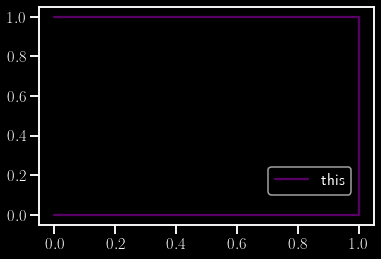

In [18]:
plt.plot([0,1,1,0],[0,0,1,1],label='this')
plt.legend(bbox_to_anchor=(0.66,0.1))

In [46]:
print([soln['dfdairmass_'+gd+'_lco'] for gd in 'griz'])

[array(-23.33145353), array(-15.65610511), array(-14.86542988), array(-8.25497978)]


In [8]:
plt.figure(figsize=(8,5))
plt.plot(alldata)

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

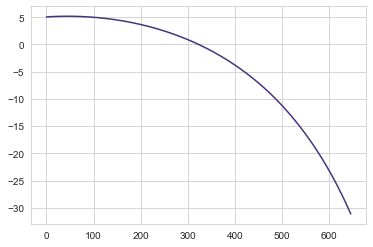

#### Figure - Cheops data:

#### Figure - Phase-folding

#### Table - All Model Variables

#### Table - Transit Times

#### Table - Planetary Properties

In [34]:
for var in combined_model.vars:
    if "TransformedDistribution" not in var and "__" not in var and "Deterministic" not in var:
        print(var)

TypeError: TensorType does not support iteration. Maybe you are using builtins.sum instead of theano.tensor.sum? (Maybe .max?)

Getting all IDs
Empty TableList


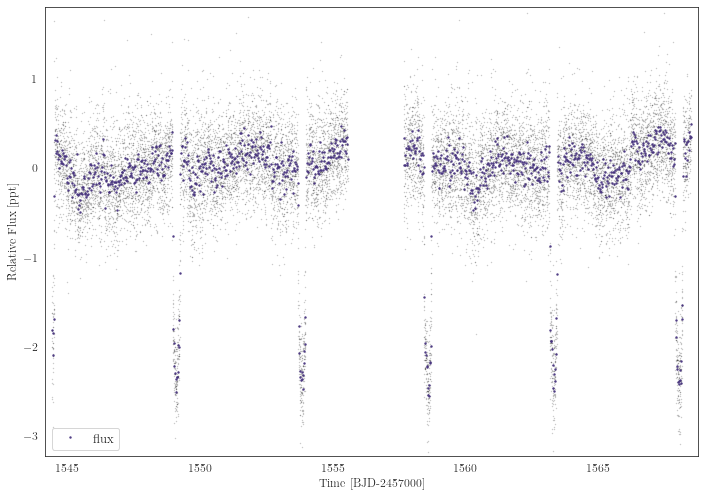

In [3]:
lc=lightcurve.multilc(55092869,'tess')
lc.plot()

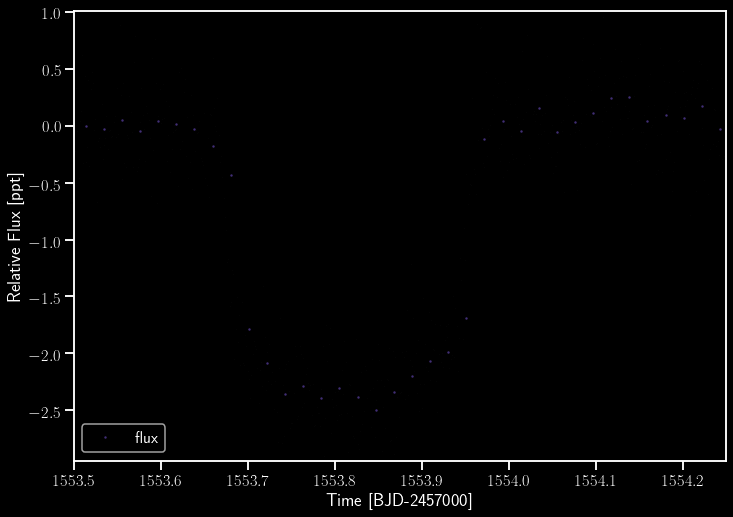

In [19]:
lc.plot(xlim=(1553.5,1554.25))

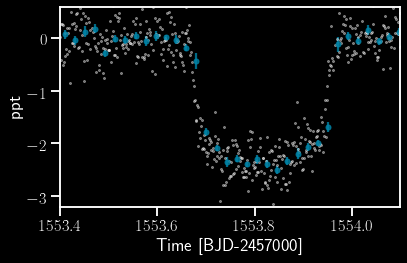

In [26]:
plt.plot(lc.time,lc.flux,'.',c='w',markersize=4,alpha=0.4)
plt.errorbar(lc.bin_time,lc.bin_flux,yerr=lc.bin_flux_err,fmt='.',markersize=10,alpha=0.8,color='C3')
plt.xlim(1553.4,1554.1)
plt.ylim(-3.2,0.6)
plt.xlabel("Time [BJD-2457000]")
plt.ylabel("ppt")
plt.tight_layout()
plt.savefig("talk_kelt-11_tess.png",dpi=400,transparent=True)

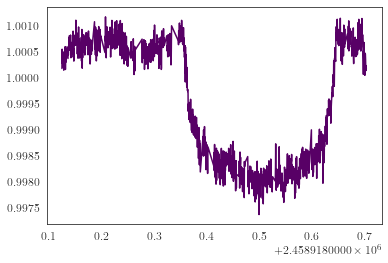

In [2]:
from astroquery.vizier import Vizier
setattr(Vizier,'ROW_LIMIT',999999999)


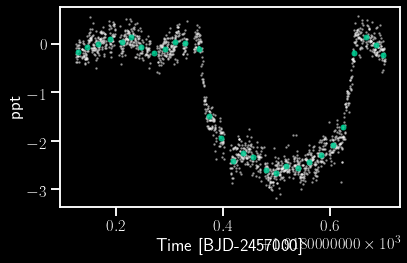

In [43]:
chlc=Vizier.get_catalogs("J/other/ExA/51.109")[0].to_pandas()

import seaborn as sns
sns.set(style="ticks", context="talk")
plt.style.use("dark_background")
sns.set_palette(viridis_light)
plt.plot(chlc['_tab1_1']-2457000,1000*(chlc['Fluxdetrend']-1),'.',c='w',markersize=3,alpha=0.4)
binchlc=tools.bin_lc_segment(np.column_stack((chlc['_tab1_1']-2457000,1000*(chlc['Fluxdetrend']-1),1000*(chlc['e_Flux']))),1/48)
plt.errorbar(binchlc[:,0],binchlc[:,1],yerr=binchlc[:,2],fmt='.',markersize=10,alpha=0.8,color='C5')

plt.xlabel("Time [BJD-2457000]")
plt.ylabel("ppt")
plt.tight_layout()
plt.savefig("talk_kelt-11_cheops.png",dpi=400,transparent=True)

In [48]:
binchlc=tools.bin_lc_segment(np.column_stack((chlc['_tab1_1']-2457000,1000*(chlc['Flux']-1),1000*(chlc['e_Flux']))),2/1440)


In [28]:
np.nanmedian(abs(np.diff(1000*chlc['Flux'])))

0.1587150000000861

In [51]:
2.65/(np.nanmedian(abs(np.diff(lc.flux)))/np.sqrt((7.14/24)/np.nanmedian(np.diff(lc.time))))

127.17445372635842

In [36]:
2.65/(np.nanmedian(abs(np.diff(1000*chlc['Flux'])))/np.sqrt((7.14/24)/np.nanmedian(np.diff(chlc['_tab1_1']))))

488.1821025099391

In [49]:
2.65/(np.nanmedian(abs(np.diff(binchlc[:,1])))/np.sqrt((7.14/24)/np.nanmedian(np.diff(binchlc[:,0]))))

409.25652823650967

In [41]:
(np.nanmedian(abs(np.diff(1000*chlc['Flux'])))/np.sqrt((1/24)/np.nanmedian(np.diff(chlc['_tab1_1']))))

0.014504846138385723

In [56]:
2650/(198/np.sqrt((7.14/24)/np.nanmedian(np.diff(chlc['_tab1_1']))))

391.3223353530658

In [57]:
allpls=ascii.read("PS_2022.01.11_07.00.30.csv").to_pandas()
thresh=4
filtdf=allpls.loc[(allpls['default_flag']==1)&(~np.isnan(allpls['pl_radeerr1']))&(allpls['tran_flag']==1)&(~np.isnan(allpls['pl_rade']))&((allpls['pl_radeerr1']/allpls['pl_rade'])<thresh)&((abs(allpls['pl_radeerr2'])/allpls['pl_rade'])<thresh)]
#&(allpls['pl_refname']!='<a refstr=HADDEN_ET_AL__2014 href=https://ui.adsabs.harvard.edu/abs/2014ApJ...787...80H/abstract target=ref> Hadden et al. 2014 </a>')&(allpls['pl_refname']!='<a refstr=XIE_2014 href=https://ui.adsabs.harvard.edu/abs/2014ApJS..210...25X/abstract target=ref>Xie 2014</a>')]

In [62]:
df=pd.read_csv("/Users/hosborn/Downloads/Duo Modelling - Clear Duos.tsv",delimiter="\t",header=1)

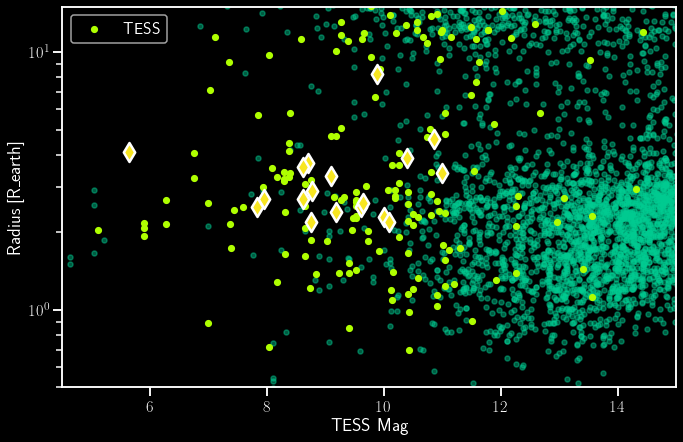

In [77]:
plt.figure(figsize=(11,7))
sns.set_palette(viridis_light)

ix2=filtdf['disc_facility']!='Transiting Exoplanet Survey Satellite (TESS)'
plt.scatter(filtdf.loc[ix2,'sy_tmag'],filtdf.loc[ix2,'pl_rade'],alpha=0.45,s=25,c='C5')
ix=filtdf['disc_facility']=='Transiting Exoplanet Survey Satellite (TESS)'
plt.scatter(filtdf.loc[ix,'sy_tmag'],filtdf.loc[ix,'pl_rade'],alpha=1,s=32,c='C7',label='TESS')
plt.scatter(df.loc[~pd.isnull(df['Period range']),'Gmag']-0.3,df.loc[~pd.isnull(df['Period range']),'Radius'],
            marker='d',s=180,edgecolors='w',color="#f8e621",linewidth=2.5)
plt.legend()
#plt.xscale('log')
plt.yscale('log')
plt.xlim(4.5,15)
plt.ylim(0.5,15)
plt.ylabel("Radius [R\_earth]")
plt.xlabel("TESS Mag")
plt.savefig("talk_transpls_by_mag_wduos.png",dpi=400,transparent=True)

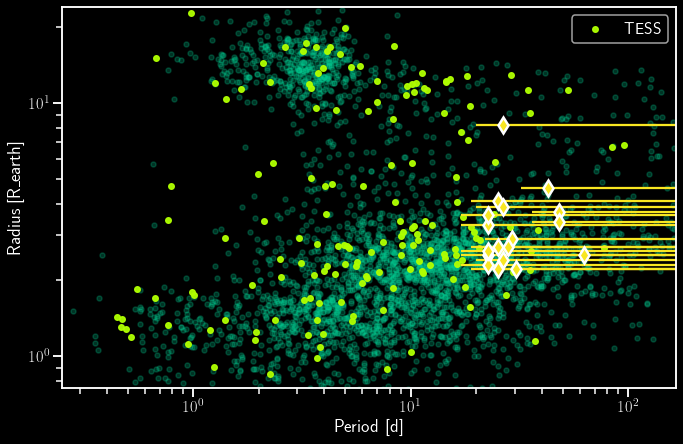

In [99]:
sns.set_palette(viridis_light)
plt.figure(figsize=(11,7))

ix2=filtdf['disc_facility']!='Transiting Exoplanet Survey Satellite (TESS)'
plt.scatter(filtdf.loc[ix2,'pl_orbper'],filtdf.loc[ix2,'pl_rade'],alpha=0.25,s=25,c='C5')
ix=filtdf['disc_facility']=='Transiting Exoplanet Survey Satellite (TESS)'
plt.scatter(filtdf.loc[ix,'pl_orbper'],filtdf.loc[ix,'pl_rade'],alpha=0.95,s=30,c='C7',label='TESS')
plt.errorbar([float(p.split('-')[0])*1.33 for p in df.loc[~pd.isnull(df['Period range']),'Period range'].values],
             df.loc[~pd.isnull(df['Period range']),'Radius'],
             xerr=[[float(p.split('-')[0])*0.33 for p in df.loc[~pd.isnull(df['Period range']),'Period range'].values],
                   [float(p.split('-')[1])-float(p.split('-')[0])*1.33 for p in df.loc[~pd.isnull(df['Period range']),'Period range'].values]],
             fmt='d',markeredgecolor='w',color="#f8e621",markersize=11.5,markeredgewidth=2.5)
plt.yscale('log')
plt.ylim(0.75,24)
plt.xlim(0.25,166)
plt.xscale('log')

plt.ylabel("Radius [R\_earth]")
plt.xlabel("Period [d]")
plt.legend()
plt.savefig("talk_transpls_by_per_wduos.png",dpi=400,transparent=True)

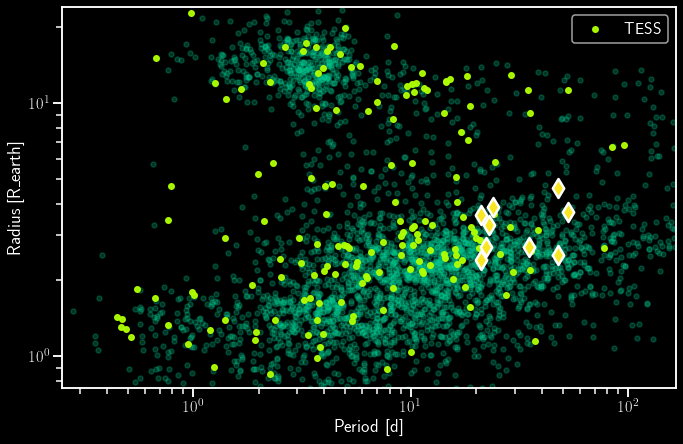

In [95]:
sns.set_palette(viridis_light)
plt.figure(figsize=(11,7))

ix2=filtdf['disc_facility']!='Transiting Exoplanet Survey Satellite (TESS)'
plt.scatter(filtdf.loc[ix2,'pl_orbper'],filtdf.loc[ix2,'pl_rade'],alpha=0.25,s=25,c='C5')
ix=filtdf['disc_facility']=='Transiting Exoplanet Survey Satellite (TESS)'
plt.scatter(filtdf.loc[ix,'pl_orbper'],filtdf.loc[ix,'pl_rade'],alpha=0.95,s=30,c='C7',label='TESS')
plt.scatter(df.loc[~pd.isnull(df['Period']),'Period'],df.loc[~pd.isnull(df['Period']),'Radius'],
            marker='d',s=180,edgecolors='w',color="#f8e621",linewidth=2.5)

plt.yscale('log')
plt.ylim(0.75,24)
plt.xlim(0.25,166)
plt.xscale('log')

plt.ylabel("Radius [R\_earth]")
plt.xlabel("Period [d]")
plt.legend()
plt.savefig("talk_transpls_by_per_wduodets.png",dpi=400,transparent=True)